# **Prediction target:**
Multi-class classification across 7 different emotions from thouands of audio files from Ravdess,TESS and CREMA-D datasets <br>
{neutral, happy, sad, angry, fear, disgust, surprise}


In [1]:
# === A. MOUNT DRIVE (once per session) ===
from google.colab import drive, auth
drive.mount('/content/drive', force_remount=False)

DRIVE_ROOT        = "/content/drive/MyDrive/multiclassproject"
RAVDESS_DIR_DRIVE = f"{DRIVE_ROOT}/Audio_Speech_Actors_01-24"
TESS_DIR_DRIVE    = f"{DRIVE_ROOT}/TESS Toronto emotional speech set data"



Mounted at /content/drive


In [2]:
# === A. MOUNT DRIVE & DEFINE PATHS ===
from google.colab import drive
import os

# Mount Google Drive (if not already mounted)
if not os.path.ismount('/content/drive'):
    drive.mount('/content/drive', force_remount=False)

# --- Define paths for datasets in Google Drive ---
DRIVE_ROOT        = "/content/drive/MyDrive/multiclassproject"
RAVDESS_DIR_DRIVE = f"{DRIVE_ROOT}/Audio_Speech_Actors_01-24"
TESS_DIR_DRIVE    = f"{DRIVE_ROOT}/TESS Toronto emotional speech set data"

# --- Path to the compressed CREMA-D file in Drive ---
CREMA_TAR_DRIVE   = f"{DRIVE_ROOT}/CREMA-D.tar.gz"

# --- LOCAL path where CREMA-D will be extracted for FAST access ---
# The tar file contains a directory named 'AudioWAV'.
CREMA_DIR_LOCAL   = "/content/AudioWAV"

print("✅ Paths defined.")
print(f"RAVDESS (Drive): {RAVDESS_DIR_DRIVE}")
print(f"TESS (Drive):    {TESS_DIR_DRIVE}")
print(f"CREMA-D (TAR):   {CREMA_TAR_DRIVE}")


# === B. EXTRACT CREMA-D TO LOCAL DISK ===
# Check if the tar file exists before trying to extract
if os.path.exists(CREMA_TAR_DRIVE):
    print(f"\nFound '{os.path.basename(CREMA_TAR_DRIVE)}'.")
    print("Extracting to local Colab disk for faster processing...")

    # Use !tar to unzip the file directly into the /content/ directory
    !tar -xzf "{CREMA_TAR_DRIVE}" -C /content/

    print(f"✅ Extraction complete. CREMA-D data is ready at: {CREMA_DIR_LOCAL}")
else:
    print(f"❌ ERROR: The file was not found at {CREMA_TAR_DRIVE}")

✅ Paths defined.
RAVDESS (Drive): /content/drive/MyDrive/multiclassproject/Audio_Speech_Actors_01-24
TESS (Drive):    /content/drive/MyDrive/multiclassproject/TESS Toronto emotional speech set data
CREMA-D (TAR):   /content/drive/MyDrive/multiclassproject/CREMA-D.tar.gz

Found 'CREMA-D.tar.gz'.
Extracting to local Colab disk for faster processing...
✅ Extraction complete. CREMA-D data is ready at: /content/AudioWAV


# **Project Setup & Naming Conventions**

In [3]:
# === TO SPEED-UP PROCESSING (All datasets via rsync) ===
import os
import subprocess
import shlex

PROJECT_NAME = "speech_emotion_ravdess_tess_crema"
DATASET_NAME = "ravdess_tess_crema_7cls"

# ---------- Ensure Drive + define source folders ----------
def ensure_drive_paths():
    """Defines and validates the source directories in Google Drive."""
    global DRIVE_ROOT, RAVDESS_DIR_DRIVE, TESS_DIR_DRIVE, CREMA_DIR_DRIVE
    if not os.path.ismount("/content/drive"):
        from google.colab import drive
        drive.mount("/content/drive", force_remount=False)

    DRIVE_ROOT = "/content/drive/MyDrive/multiclassproject"
    RAVDESS_DIR_DRIVE = f"{DRIVE_ROOT}/Audio_Speech_Actors_01-24"
    TESS_DIR_DRIVE = f"{DRIVE_ROOT}/TESS Toronto emotional speech set data"
    # Path to the CREMA-D FOLDER in Drive, as seen in your screenshot
    CREMA_DIR_DRIVE = f"{DRIVE_ROOT}/crema"

    assert os.path.isdir(RAVDESS_DIR_DRIVE), f"Missing: {RAVDESS_DIR_DRIVE}"
    assert os.path.isdir(TESS_DIR_DRIVE), f"Missing: {TESS_DIR_DRIVE}"
    assert os.path.isdir(CREMA_DIR_DRIVE), f"Missing: {CREMA_DIR_DRIVE}"
    print("✅ All source directories found in Google Drive.")

ensure_drive_paths()

# ---------- Local workspace (FAST) ----------
LOCAL_ROOT = f"/content/data/{PROJECT_NAME}"
LOCAL_RAVDESS = f"{LOCAL_ROOT}/RAVDESS"
LOCAL_TESS = f"{LOCAL_ROOT}/TESS"
LOCAL_CREMA = f"{LOCAL_ROOT}/CREMA"  # Consistent local directory name
os.makedirs(LOCAL_RAVDESS, exist_ok=True)
os.makedirs(LOCAL_TESS, exist_ok=True)
os.makedirs(LOCAL_CREMA, exist_ok=True)

# --- knobs ---
FORCE_RESYNC = False

# ---------- helpers ----------
def _count_wavs(path: str) -> int:
    """Counts .wav files in a given directory path."""
    if not os.path.isdir(path):
        return 0
    try:
        out = subprocess.check_output(f'find "{path}" -type f -iname "*.wav" | wc -l', shell=True).decode().strip()
        return int(out or 0)
    except subprocess.CalledProcessError:
        return 0

def _mirror_rsync(src: str, dst: str, label: str):
    """Mirrors a source directory to a destination using rsync."""
    os.makedirs(dst, exist_ok=True)
    args = ['rsync', '-a', '--delete', '--info=progress2', src.rstrip('/') + '/', dst]
    print(f"[{label}] Mirroring Drive → Local (rsync)...")
    subprocess.run(args, check=True)

# ---------- main: ensure all local data is synced via rsync ----------
def ensure_local_data():
    """Checks if local data matches Drive and syncs if necessary."""
    print("--- Checking status of local dataset copies ---")
    # Get file counts from both Drive and local for all three datasets
    rav_drive_count = _count_wavs(RAVDESS_DIR_DRIVE)
    tess_drive_count = _count_wavs(TESS_DIR_DRIVE)
    crema_drive_count = _count_wavs(CREMA_DIR_DRIVE)

    rav_local_count = _count_wavs(LOCAL_RAVDESS)
    tess_local_count = _count_wavs(LOCAL_TESS)
    crema_local_count = _count_wavs(LOCAL_CREMA)

    # Check if any of the datasets are incomplete locally
    needs_sync = (
        FORCE_RESYNC or
        rav_local_count < rav_drive_count * 0.98 or
        tess_local_count < tess_drive_count * 0.98 or
        crema_local_count < crema_drive_count * 0.98
    )

    if needs_sync:
        print("One or more datasets are incomplete locally. Syncing all datasets...")
        _mirror_rsync(RAVDESS_DIR_DRIVE, LOCAL_RAVDESS, "RAVDESS")
        _mirror_rsync(TESS_DIR_DRIVE,    LOCAL_TESS,    "TESS")
        _mirror_rsync(CREMA_DIR_DRIVE,   LOCAL_CREMA,   "CREMA-D")
    else:
        print("✅ All dataset copies are up-to-date. Skipping sync.")

ensure_local_data()

# ---------- Use LOCAL paths from now on ----------
RAVDESS_DIR = LOCAL_RAVDESS
TESS_DIR = LOCAL_TESS
CREMA_DIR = LOCAL_CREMA

# ---------- Inventory (after sync) ----------
rav_count = _count_wavs(RAVDESS_DIR)
tess_count = _count_wavs(TESS_DIR)
crema_count = _count_wavs(CREMA_DIR)
print("\nREADY — working locally on the VM SSD")
print(f"RAVDESS local: {RAVDESS_DIR}  -> {rav_count} wavs")
print(f"TESS    local: {TESS_DIR}     -> {tess_count} wavs")
print(f"CREMA-D local: {CREMA_DIR}    -> {crema_count} wavs")

✅ All source directories found in Google Drive.
--- Checking status of local dataset copies ---
One or more datasets are incomplete locally. Syncing all datasets...
[RAVDESS] Mirroring Drive → Local (rsync)...
[TESS] Mirroring Drive → Local (rsync)...
[CREMA-D] Mirroring Drive → Local (rsync)...

READY — working locally on the VM SSD
RAVDESS local: /content/data/speech_emotion_ravdess_tess_crema/RAVDESS  -> 1440 wavs
TESS    local: /content/data/speech_emotion_ravdess_tess_crema/TESS     -> 2800 wavs
CREMA-D local: /content/data/speech_emotion_ravdess_tess_crema/CREMA    -> 7442 wavs


In [4]:
# === 1. IMPORTS & CONFIG ===
import os, glob, re, random, warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

import librosa
import librosa.display
from IPython.display import Audio
from tqdm import tqdm

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    balanced_accuracy_score,
    roc_auc_score,
    cohen_kappa_score,
    matthews_corrcoef,
    classification_report,
    confusion_matrix
)




**RAW FILE STRUCTURE & LABELS**<br>
**Objective:**


*  To show how RAVDESS,TESS and CREMA-D emotion filenames were encoded.
*  Detect the raw labels each dataset exposes
*  To understand how the mapping sequence should be done to be able to merge the two set of files.<br> (Naming and set of emotion categories)


In [5]:
# === 1A. RAW INSPECTION (Corrected for nested CREMA-D) ===

CREMA_AUDIO_DIR = os.path.join(CREMA_DIR, "AudioWAV")
print(f"Corrected path for CREMA-D audio: {CREMA_AUDIO_DIR}")


def sample_files(root, n=8):
    out = []
    for d,_,files in os.walk(root):
        for fn in files:
            if fn.lower().endswith(".wav"):
                out.append(os.path.join(d, fn))
                if len(out) >= n:
                    return out
    return out

print("\nSample RAVDESS files:")
for p in sample_files(RAVDESS_DIR): print("  ", os.path.basename(p))

print("\nSample TESS files:")
for p in sample_files(TESS_DIR): print("  ", os.path.basename(p))

# Use the corrected path to sample files
print("\nSample CREMA-D files:")
for p in sample_files(CREMA_AUDIO_DIR): print("  ", os.path.basename(p))


# --- Extract RAW labels straight from filenames (dataset-native) ---
RAVDESS_EMOTION_CODEBOOK = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fear', '07': 'disgust', '08': 'surprise'
}

def ravdess_raw_labels(ravdess_dir):
    rows = []
    for d,_,files in os.walk(ravdess_dir):
        for fn in files:
            if not fn.lower().endswith(".wav"): continue
            parts = fn.split('-')
            label = RAVDESS_EMOTION_CODEBOOK.get(parts[2]) if len(parts) > 2 else None
            rows.append({"dataset":"RAVDESS","path":os.path.join(d,fn),"raw_label":label,"file":fn})
    return pd.DataFrame(rows)

def tess_raw_labels(tess_dir):
    rows = []
    for d,_,files in os.walk(tess_dir):
        for fn in files:
            if not fn.lower().endswith(".wav"): continue
            emotion = fn.split('_')[-1].split('.')[0] if '_' in fn else None
            rows.append({"dataset":"TESS","path":os.path.join(d,fn),"raw_label":emotion,"file":fn})
    return pd.DataFrame(rows)

# MODIFIED to handle the nested 'AudioWAV' folder
def crema_raw_labels(crema_audio_dir):
    rows = []
    # Use os.walk to robustly find files in subdirectories
    for d, _, files in os.walk(crema_audio_dir):
        for fn in files:
            if not fn.lower().endswith(".wav"): continue
            # Filename: 1001_DFA_ANG_XX.wav -> Emotion is the 3rd part
            parts = fn.split('_')
            label = parts[2] if len(parts) > 2 else None
            rows.append({"dataset":"CREMA-D", "path":os.path.join(d, fn), "raw_label":label, "file":fn})
    return pd.DataFrame(rows)


rav_raw = ravdess_raw_labels(RAVDESS_DIR)
tes_raw = tess_raw_labels(TESS_DIR)
# Call the function with the corrected path
crema_raw = crema_raw_labels(CREMA_AUDIO_DIR)

raw_df = pd.concat([rav_raw, tes_raw, crema_raw], ignore_index=True)

print("\n--- Distinct RAW labels per dataset (BEFORE any cleaning/mapping) ---")
for name, sub in raw_df.groupby("dataset"):
    print(f"\n{name}:")
    print(sub["raw_label"].value_counts(dropna=False).sort_index())

print("\n--- Quick mismatch check (RAW) ---")
rav_set_raw = set(rav_raw["raw_label"].dropna().unique())
tes_set_raw = set(tes_raw["raw_label"].dropna().unique())
crema_set_raw = set(crema_raw["raw_label"].dropna().unique())

print("RAVDESS raw set:", sorted(rav_set_raw))
print("TESS    raw set:", sorted(tes_set_raw))
print("CREMA-D raw set:", sorted(crema_set_raw))
print("\n--- Differences ---")
print("Only-in-RAVDESS (vs all):", sorted(rav_set_raw - tes_set_raw - crema_set_raw))
print("Only-in-TESS    (vs all):", sorted(tes_set_raw - rav_set_raw - crema_set_raw))
print("Only-in-CREMA-D (vs all):", sorted(crema_set_raw - rav_set_raw - tes_set_raw))

Corrected path for CREMA-D audio: /content/data/speech_emotion_ravdess_tess_crema/CREMA/AudioWAV

Sample RAVDESS files:
   03-01-06-01-02-01-09.wav
   03-01-08-02-02-02-09.wav
   03-01-04-01-01-01-09.wav
   03-01-03-02-02-01-09.wav
   03-01-05-01-02-01-09.wav
   03-01-07-01-02-02-09.wav
   03-01-04-01-01-02-09.wav
   03-01-07-02-02-02-09.wav

Sample TESS files:
   OAF_pool_disgust.wav
   OAF_dime_disgust.wav
   OAF_soap_disgust.wav
   OAF_met_disgust.wav
   OAF_young_disgust.wav
   OAF_hole_disgust.wav
   OAF_wire_disgust.wav
   OAF_size_disgust.wav

Sample CREMA-D files:
   1037_IWL_DIS_XX.wav
   1069_TAI_DIS_XX.wav
   1058_ITH_HAP_XX.wav
   1013_WSI_ANG_XX.wav
   1025_IEO_DIS_MD.wav
   1083_DFA_FEA_XX.wav
   1010_WSI_SAD_XX.wav
   1027_IOM_NEU_XX.wav

--- Distinct RAW labels per dataset (BEFORE any cleaning/mapping) ---

CREMA-D:
raw_label
ANG    1271
DIS    1271
FEA    1271
HAP    1271
NEU    1087
SAD    1271
Name: count, dtype: int64

RAVDESS:
raw_label
angry       192
calm        

**Initial cleaning of the dataset format**

1.   Lowercasing all labels

  *   Example:Ensures "Happy" and "happy" are treated the same
  *   This removes differences caused by inconsistent capital letters

2.   Removing all leading/trailing spaces

  *   Removes extra spaces "happy_" with a space to avoid being counted as a separate label from "happy"

3.   Normalization of common variations

  *   Example:converting "pleasant_surprise" to "ps" so we can see it as the same shorthand form used in other files.
  *   This is still not mapping to "surprise" yet — just making the form consistent.

**Outcome:**
  *   This step usually reduces the number of unique labels (because duplicates collapse).
  *   It makes the set difference check between datasets more accurate — now it highlights real mismatches instead of superficial ones.


In [6]:
# === 1B. LIGHT CLEANING —  ===
# Objective: show how simple normalization changes the comparison

def normalize_for_display(s):
    return (
        s.astype(str)          # handle None/NaN uniformly
         .str.strip()
         .str.lower()
         .str.replace('pleasant_surprise', 'ps', regex=False)  # optional: unify common variations
    )

clean_df = raw_df.copy()
clean_df["raw_label_clean"] = normalize_for_display(clean_df["raw_label"])

print("\n--- Distinct labels after LIGHT CLEAN (lowercase/strip only) ---")
# This loop already works for all datasets, including CREMA-D
for name, sub in clean_df.groupby("dataset"):
    print(f"\n{name} (clean view):")
    print(sub["raw_label_clean"].value_counts(dropna=False).sort_index())

# --- MODIFIED FOR 3-WAY COMPARISON ---
print("\n--- Quick mismatch check (CLEAN VIEW) ---")
rav_set_clean = set(clean_df.loc[clean_df.dataset=="RAVDESS","raw_label_clean"].dropna().unique())
tes_set_clean = set(clean_df.loc[clean_df.dataset=="TESS","raw_label_clean"].dropna().unique())
# ADDED FOR CREMA-D
crema_set_clean = set(clean_df.loc[clean_df.dataset=="CREMA-D","raw_label_clean"].dropna().unique())

print("RAVDESS clean set:", sorted(rav_set_clean))
print("TESS    clean set:", sorted(tes_set_clean))
print("CREMA-D clean set:", sorted(crema_set_clean)) # ADDED FOR CREMA-D
print("\n--- Differences (CLEAN VIEW) ---")
print("Only-in-RAVDESS (vs all):", sorted(rav_set_clean - tes_set_clean - crema_set_clean))
print("Only-in-TESS    (vs all):", sorted(tes_set_clean - rav_set_clean - crema_set_clean))
print("Only-in-CREMA-D (vs all):", sorted(crema_set_clean - rav_set_clean - tes_set_clean))


--- Distinct labels after LIGHT CLEAN (lowercase/strip only) ---

CREMA-D (clean view):
raw_label_clean
ang    1271
dis    1271
fea    1271
hap    1271
neu    1087
sad    1271
Name: count, dtype: int64

RAVDESS (clean view):
raw_label_clean
angry       192
calm        192
disgust     192
fear        192
happy       192
neutral      96
sad         192
surprise    192
Name: count, dtype: int64

TESS (clean view):
raw_label_clean
angry      400
disgust    400
fear       400
happy      400
neutral    400
ps         400
sad        400
Name: count, dtype: int64

--- Quick mismatch check (CLEAN VIEW) ---
RAVDESS clean set: ['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
TESS    clean set: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad']
CREMA-D clean set: ['ang', 'dis', 'fea', 'hap', 'neu', 'sad']

--- Differences (CLEAN VIEW) ---
Only-in-RAVDESS (vs all): ['calm', 'surprise']
Only-in-TESS    (vs all): ['ps']
Only-in-CREMA-D (vs all): ['ang', 'dis', '

**Mapping of filenames on the dataset to native labels.** <br>

This step converts the raw labels from each dataset's filenames into a standardized set of emotion words. The process differs per dataset.

*   decodes RAVDESS emotion codes into words using the codebook. <br>
*   For RAVDESS: Decodes numeric emotion codes (e.g., '03') into full words ('happy') using its specific codebook.
  > RAVDESS_EMOTION_CODEBOOK = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fear', '07': 'disgust', '08': 'surprise'
}
*   For TESS dataset, extracts the word (e.g., happy, ps) directly from the end of the filename.

*   For CREMA-D: Similarly, decodes three-letter abbreviations (e.g., 'HAP') into full words ('happy') using the CREMA-D codebook.

*   For all datasets: The final label_mapped is created by converting the resulting word to lowercase and stripping any extra spaces to ensure consistency across the entire collection.


In [7]:
# === DATA LOADING — DATASET-NATIVE MAPPING ===


# Ensure we are pointing to the correct subdirectory containing the audio files.
CREMA_AUDIO_DIR = os.path.join(CREMA_DIR, "AudioWAV")

RAVDESS_EMOTION_CODEBOOK = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fear', '07': 'disgust', '08': 'surprise'
}

# ADDED FOR CREMA-D: Maps 3-letter code to the emotion word.
CREMA_EMOTION_CODEBOOK = {
    'ANG': 'angry',
    'DIS': 'disgust',
    'FEA': 'fear',
    'HAP': 'happy',
    'NEU': 'neutral',
    'SAD': 'sad'
}

def load_ravdess_native(ravdess_dir):
    paths, raw = [], []
    for dirname, _, files in os.walk(ravdess_dir):
        for fn in files:
            if not fn.lower().endswith(".wav"):
                continue
            parts = fn.split('-')
            label = RAVDESS_EMOTION_CODEBOOK.get(parts[2]) if len(parts) > 2 else None
            paths.append(os.path.join(dirname, fn))
            raw.append(label)
    df = pd.DataFrame({"dataset":"RAVDESS","path":paths,"label_raw":raw})
    df["label_mapped"] = df["label_raw"].astype(str).str.strip().str.lower()
    return df

def load_tess_native(tess_dir):
    paths, raw = [], []
    for dirname, _, files in os.walk(tess_dir):
        for fn in files:
            if not fn.lower().endswith(".wav"):
                continue
            token = fn.split('_')[-1].split('.')[0] if '_' in fn else None
            paths.append(os.path.join(dirname, fn))
            raw.append(token)
    df = pd.DataFrame({"dataset":"TESS","path":paths,"label_raw":raw})
    df["label_mapped"] = df["label_raw"].astype(str).str.strip().str.lower()
    return df

# ADDED FOR CREMA-D
def load_crema_native(crema_audio_dir):
    paths, raw = [], []
    for dirname, _, files in os.walk(crema_audio_dir):
        for fn in files:
            if not fn.lower().endswith(".wav"):
                continue
            # Filename: 1001_DFA_ANG_XX.wav -> Emotion code is the 3rd part
            parts = fn.split('_')
            code = parts[2] if len(parts) > 2 else None
            label = CREMA_EMOTION_CODEBOOK.get(code) # Use the codebook to get the full word
            paths.append(os.path.join(dirname, fn))
            raw.append(label) # label_raw will be 'angry', 'sad', etc.
    df = pd.DataFrame({"dataset":"CREMA-D","path":paths,"label_raw":raw})
    df["label_mapped"] = df["label_raw"].astype(str).str.strip().str.lower()
    return df

rav_native = load_ravdess_native(RAVDESS_DIR)
tess_native = load_tess_native(TESS_DIR)
crema_native = load_crema_native(CREMA_AUDIO_DIR) # ADDED

# MODIFIED to include CREMA-D
native_df = pd.concat([rav_native, tess_native, crema_native], ignore_index=True)

print("--- Dataset-native labels (label_mapped) ---")
for name, sub in native_df.groupby("dataset"):
    print(f"\n{name} counts:")
    print(sub["label_mapped"].value_counts(dropna=False).sort_index())

--- Dataset-native labels (label_mapped) ---

CREMA-D counts:
label_mapped
angry      1271
disgust    1271
fear       1271
happy      1271
neutral    1087
sad        1271
Name: count, dtype: int64

RAVDESS counts:
label_mapped
angry       192
calm        192
disgust     192
fear        192
happy       192
neutral      96
sad         192
surprise    192
Name: count, dtype: int64

TESS counts:
label_mapped
angry      400
disgust    400
fear       400
happy      400
neutral    400
ps         400
sad        400
Name: count, dtype: int64


**Merging of all datasets into a  7-class emotion category** <br>
Objective: convert both datasets’ labels to the same final vocabulary for training.

*   calm → neutral
*   fearful → fear
*   ps or pleasant_surprise → surprise
*   also ensure all lowercased


In [8]:
# === HARMONIZATION — map dataset-native labels to final taxonomy ===

FINAL_TAXONOMY = ['neutral','happy','sad','angry','fear','disgust','surprise']

HARMONIZE_MAP = {
    # normalize synonyms/variants
    'fearful': 'fear',
    'pleasant_surprise': 'surprise',
    'ps': 'surprise',
    # merge categories as decided
    'calm': 'neutral',
}

def harmonize_labels(df):
    out = df.copy()
    # start from label_mapped (already lowercase/strip)
    out["label_final"] = out["label_mapped"].replace(HARMONIZE_MAP)
    # keep everything lowercase just in case
    out["label_final"] = out["label_final"].astype(str).str.strip().str.lower()
    return out

harm_df = harmonize_labels(native_df)

print("\n--- 2B: Harmonized labels (label_final) ---")
for name, sub in harm_df.groupby("dataset"):
    print(f"\n{name} counts:")
    print(sub["label_final"].value_counts(dropna=False).sort_index())



--- 2B: Harmonized labels (label_final) ---

CREMA-D counts:
label_final
angry      1271
disgust    1271
fear       1271
happy      1271
neutral    1087
sad        1271
Name: count, dtype: int64

RAVDESS counts:
label_final
angry       192
disgust     192
fear        192
happy       192
neutral     288
sad         192
surprise    192
Name: count, dtype: int64

TESS counts:
label_final
angry       400
disgust     400
fear        400
happy       400
neutral     400
sad         400
surprise    400
Name: count, dtype: int64


# Merging of labels and emotions for both datasets

In [9]:
# === VALIDATION & FILTERING TO FINAL TAXONOMY ===

def filter_to_final_taxonomy(df, allowed=FINAL_TAXONOMY):
    before = len(df)
    keep_mask = df["label_final"].isin(allowed)
    dropped = (~keep_mask).sum()
    filtered = df[keep_mask].reset_index(drop=True)
    print(f"\nKept {len(filtered)}/{before} files. Dropped {dropped} not in final taxonomy.")
    print("Final label set:", sorted(filtered["label_final"].unique()))
    return filtered

df = filter_to_final_taxonomy(harm_df)

# (Optional) tidy columns for modeling
df = df[["path","label_final"]].rename(columns={"label_final":"label"})

print("\nTotal files for training:", len(df))
print("Labels:", sorted(df['label'].unique()))
df.head()



Kept 11682/11682 files. Dropped 0 not in final taxonomy.
Final label set: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Total files for training: 11682
Labels: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


,path,label
0,/content/data/speech_emotion_ravdess_tess_crem...,fear
1,/content/data/speech_emotion_ravdess_tess_crem...,surprise
2,/content/data/speech_emotion_ravdess_tess_crem...,sad
3,/content/data/speech_emotion_ravdess_tess_crem...,happy
4,/content/data/speech_emotion_ravdess_tess_crem...,angry


# Second set of Data format cleaning

*   Remove missing paths or labels (dropna)
*   Remove duplicate file entries
  * This step prevents errors during model training and guarantees that each row corresponds to a valid, unique audio file with a clean label
*   Keep only files that still exist on disk (os.path.exists)
  * We checked that each path actually points to an existing .wav file.





In [10]:
# === DATASET CLEANING ===
# Drop rows with missing path/label
df = df.dropna(subset=['path','label']).copy()

# Keep only files that actually exist
df = df[df['path'].apply(os.path.exists)].reset_index(drop=True)

# Drop duplicate file paths (safety)
df = df.drop_duplicates(subset=['path']).reset_index(drop=True)

print("After basic cleaning:", df.shape)


After basic cleaning: (11682, 2)


# **EDA of Audio files**
Loading of raw audio & diagnostics.

*   How files are stored (sample rate, channels)
*   How loud they are (peak amplitude)
*   How much silence they contain before and after speech

**Step-by-step flow of execution**
1. Loading the file as-is

  *   Librosa is used to load (librosa.load) and not to resample (sr=None) and not to force mono (mono=False), so we can get the original sample rate and channel count.
  *   This preserves the raw condition of the file for inspection.

2. Convert to mono for measurement for diagnostic purposes only

  *   Even though the file may be stereo, most of our stats (RMS, peak, silence) are easier to compare if they’re based on a single combined channel.

3. Calculate audio metrics

  *   Sample rate (sr): How many samples per second the audio was originally recorded at. This can vary a lot between datasets.
  *   Duration (seconds): How long the clip is from start to finish.

  *   Peak amplitude: The loudest point in the clip (absolute value). This shows whether the file is too quiet or too loud.
  *   RMS (Root Mean Square) level in dB: The average power/loudness of the clip. RMS is more reliable than peak for measuring perceived volume.

  *   Leading silence (ms): How much quiet time exists before speech starts.
  *   Trailing silence (ms): How much quiet time exists after speech ends.

    * We used librosa.effects.trim to detect where the non-silent portion begins and ends.
4. Return all metrics in a dictionary
  *  This makes it easy to print, store, or compare against later cleaning stages.


**Key points to look for:**

*   If the sample rates vary (e.g., 44.1 kHz, 48 kHz, 22.05 kHz) then resampling is required
*   If many audio files have 2-3 seconds of leading silence, then trimming of the silence is required.
  *   Trimming will save model training from learning "silence patterns"
*   If RMS levels are not consistent then normalization will help features focus on actual speech content instead of volume differences.



STEP 1 — RAW LOAD (EDA - MULTI-SAMPLE VIEW)
TESS DATASET — one raw sample per emotion

### Emotion: angry
────────────────────────────────────────────────────────────────────────
RAW AUDIO SUMMARY
────────────────────────────────────────────────────────────────────────
File:                /content/data/speech_emotion_ravdess_tess_crema/TESS/OAF_angry/OAF_room_angry.wav
File size:           73.5 KB
Sample rate (Hz):    24414
Channels:            1  (mono)
Samples / channel:   37,596
Duration:            1.540 sec  (00:02)
Max amplitude:       0.1869 (min)  |  0.1869 (|max|)
Mean amplitude:      -0.0001  (DC offset check)
Clipping (>=0.999):  0.000% of samples
────────────────────────────────────────────────────────────────────────


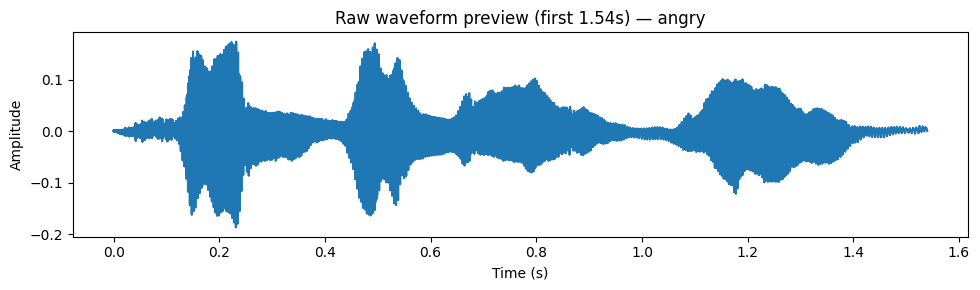


### Emotion: disgust
────────────────────────────────────────────────────────────────────────
RAW AUDIO SUMMARY
────────────────────────────────────────────────────────────────────────
File:                /content/data/speech_emotion_ravdess_tess_crema/TESS/OAF_disgust/OAF_sure_disgust.wav
File size:           108.3 KB
Sample rate (Hz):    24414
Channels:            1  (mono)
Samples / channel:   55,433
Duration:            2.271 sec  (00:02)
Max amplitude:       0.0916 (min)  |  0.0916 (|max|)
Mean amplitude:      0.0001  (DC offset check)
Clipping (>=0.999):  0.000% of samples
────────────────────────────────────────────────────────────────────────


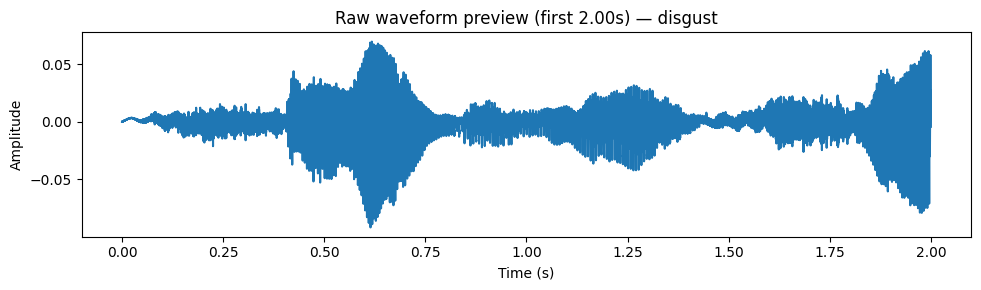


### Emotion: fear
────────────────────────────────────────────────────────────────────────
RAW AUDIO SUMMARY
────────────────────────────────────────────────────────────────────────
File:                /content/data/speech_emotion_ravdess_tess_crema/TESS/YAF_fear/YAF_mill_fear.wav
File size:           72.8 KB
Sample rate (Hz):    24414
Channels:            1  (mono)
Samples / channel:   37,236
Duration:            1.525 sec  (00:02)
Max amplitude:       0.2538 (min)  |  0.2538 (|max|)
Mean amplitude:      -0.0001  (DC offset check)
Clipping (>=0.999):  0.000% of samples
────────────────────────────────────────────────────────────────────────


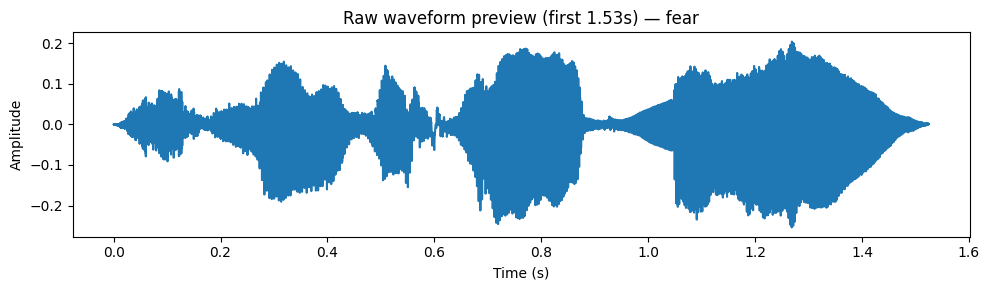


### Emotion: happy
────────────────────────────────────────────────────────────────────────
RAW AUDIO SUMMARY
────────────────────────────────────────────────────────────────────────
File:                /content/data/speech_emotion_ravdess_tess_crema/TESS/YAF_happy/YAF_bite_happy.wav
File size:           90.5 KB
Sample rate (Hz):    24414
Channels:            1  (mono)
Samples / channel:   46,338
Duration:            1.898 sec  (00:02)
Max amplitude:       0.5662 (min)  |  0.5662 (|max|)
Mean amplitude:      -0.0000  (DC offset check)
Clipping (>=0.999):  0.000% of samples
────────────────────────────────────────────────────────────────────────


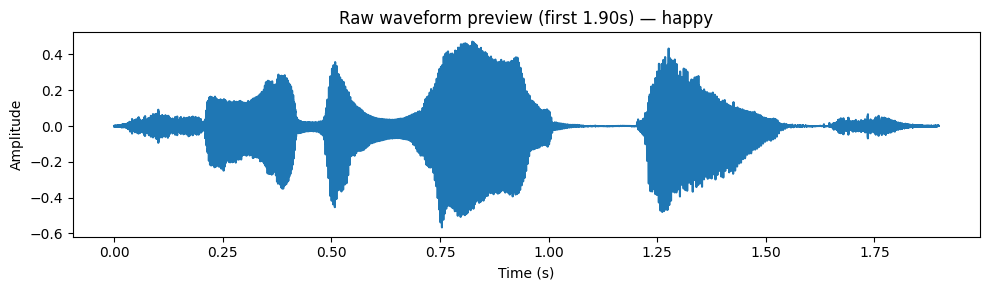


### Emotion: neutral
────────────────────────────────────────────────────────────────────────
RAW AUDIO SUMMARY
────────────────────────────────────────────────────────────────────────
File:                /content/data/speech_emotion_ravdess_tess_crema/TESS/OAF_neutral/OAF_cab_neutral.wav
File size:           91.0 KB
Sample rate (Hz):    24414
Channels:            1  (mono)
Samples / channel:   46,556
Duration:            1.907 sec  (00:02)
Max amplitude:       0.0522 (min)  |  0.0522 (|max|)
Mean amplitude:      -0.0000  (DC offset check)
Clipping (>=0.999):  0.000% of samples
────────────────────────────────────────────────────────────────────────


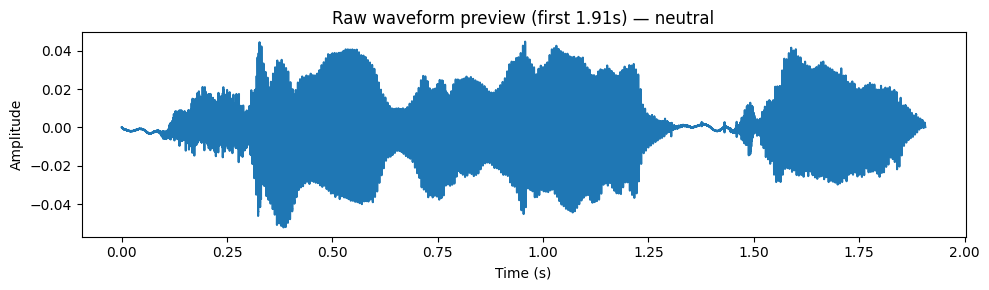


### Emotion: sad
────────────────────────────────────────────────────────────────────────
RAW AUDIO SUMMARY
────────────────────────────────────────────────────────────────────────
File:                /content/data/speech_emotion_ravdess_tess_crema/TESS/YAF_sad/YAF_luck_sad.wav
File size:           108.7 KB
Sample rate (Hz):    24414
Channels:            1  (mono)
Samples / channel:   55,652
Duration:            2.280 sec  (00:02)
Max amplitude:       0.1818 (min)  |  0.1818 (|max|)
Mean amplitude:      -0.0000  (DC offset check)
Clipping (>=0.999):  0.000% of samples
────────────────────────────────────────────────────────────────────────


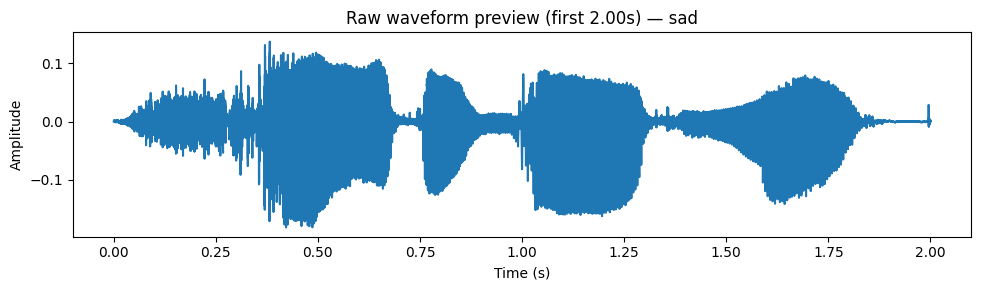

RAVDESS — one raw sample per emotion

### Emotion: angry
────────────────────────────────────────────────────────────────────────
RAW AUDIO SUMMARY
────────────────────────────────────────────────────────────────────────
File:                /content/data/speech_emotion_ravdess_tess_crema/RAVDESS/Actor_19/03-01-05-02-01-01-19.wav
File size:           419.2 KB
Sample rate (Hz):    48000
Channels:            1  (mono)
Samples / channel:   190,591
Duration:            3.971 sec  (00:04)
Max amplitude:       0.8414 (min)  |  0.9756 (|max|)
Mean amplitude:      0.0000  (DC offset check)
Clipping (>=0.999):  0.000% of samples
────────────────────────────────────────────────────────────────────────


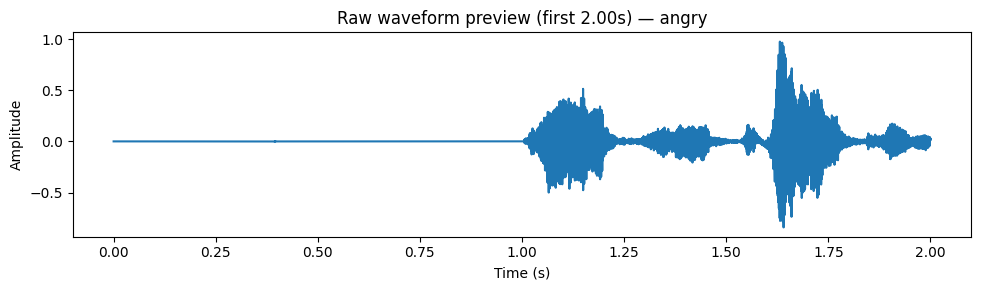


### Emotion: calm
────────────────────────────────────────────────────────────────────────
RAW AUDIO SUMMARY
────────────────────────────────────────────────────────────────────────
File:                /content/data/speech_emotion_ravdess_tess_crema/RAVDESS/Actor_24/03-01-02-02-02-01-24.wav
File size:           433.6 KB
Sample rate (Hz):    48000
Channels:            1  (mono)
Samples / channel:   193,794
Duration:            4.037 sec  (00:04)
Max amplitude:       0.0235 (min)  |  0.0313 (|max|)
Mean amplitude:      -0.0000  (DC offset check)
Clipping (>=0.999):  0.000% of samples
────────────────────────────────────────────────────────────────────────


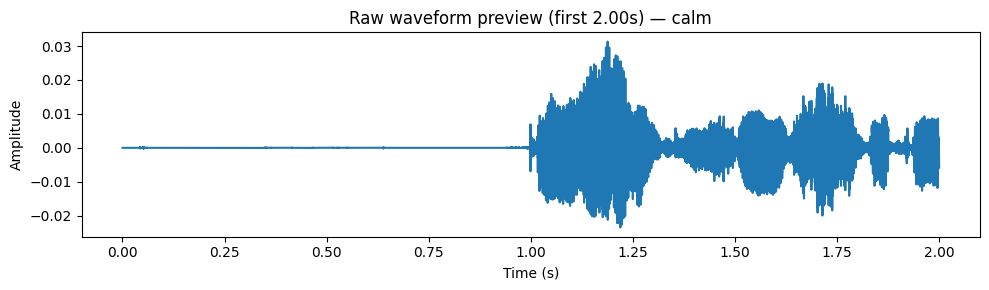


### Emotion: disgust
────────────────────────────────────────────────────────────────────────
RAW AUDIO SUMMARY
────────────────────────────────────────────────────────────────────────
File:                /content/data/speech_emotion_ravdess_tess_crema/RAVDESS/Actor_22/03-01-07-01-01-02-22.wav
File size:           423.1 KB
Sample rate (Hz):    48000
Channels:            1  (mono)
Samples / channel:   187,387
Duration:            3.904 sec  (00:04)
Max amplitude:       0.0916 (min)  |  0.0916 (|max|)
Mean amplitude:      -0.0000  (DC offset check)
Clipping (>=0.999):  0.000% of samples
────────────────────────────────────────────────────────────────────────


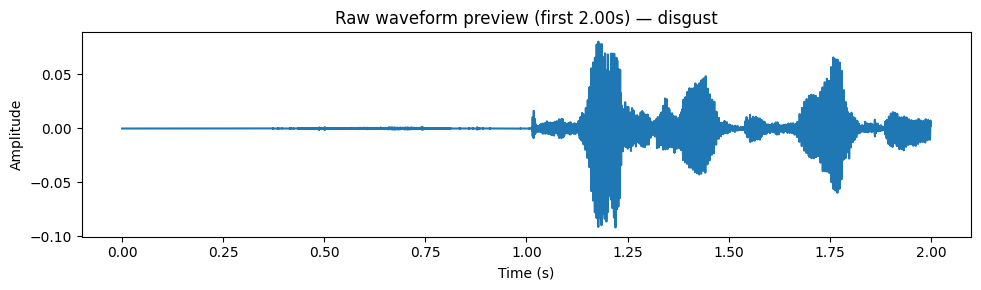


### Emotion: fear
────────────────────────────────────────────────────────────────────────
RAW AUDIO SUMMARY
────────────────────────────────────────────────────────────────────────
File:                /content/data/speech_emotion_ravdess_tess_crema/RAVDESS/Actor_20/03-01-06-02-01-01-20.wav
File size:           455.8 KB
Sample rate (Hz):    48000
Channels:            1  (mono)
Samples / channel:   203,403
Duration:            4.238 sec  (00:04)
Max amplitude:       0.7224 (min)  |  0.8069 (|max|)
Mean amplitude:      -0.0000  (DC offset check)
Clipping (>=0.999):  0.000% of samples
────────────────────────────────────────────────────────────────────────


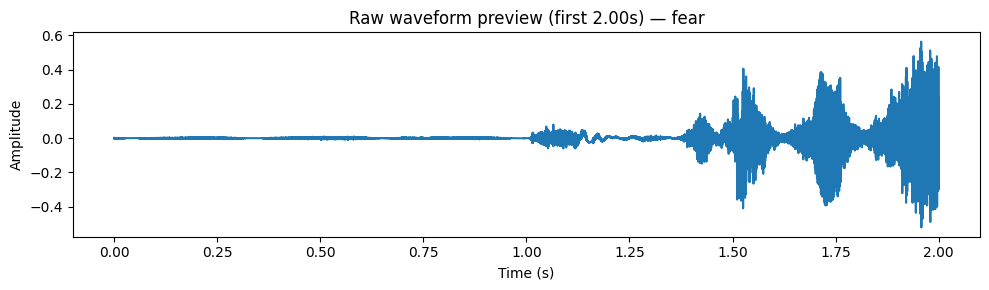


### Emotion: happy
────────────────────────────────────────────────────────────────────────
RAW AUDIO SUMMARY
────────────────────────────────────────────────────────────────────────
File:                /content/data/speech_emotion_ravdess_tess_crema/RAVDESS/Actor_14/03-01-03-01-02-02-14.wav
File size:           384.9 KB
Sample rate (Hz):    48000
Channels:            1  (mono)
Samples / channel:   166,566
Duration:            3.470 sec  (00:03)
Max amplitude:       0.0738 (min)  |  0.0913 (|max|)
Mean amplitude:      0.0000  (DC offset check)
Clipping (>=0.999):  0.000% of samples
────────────────────────────────────────────────────────────────────────


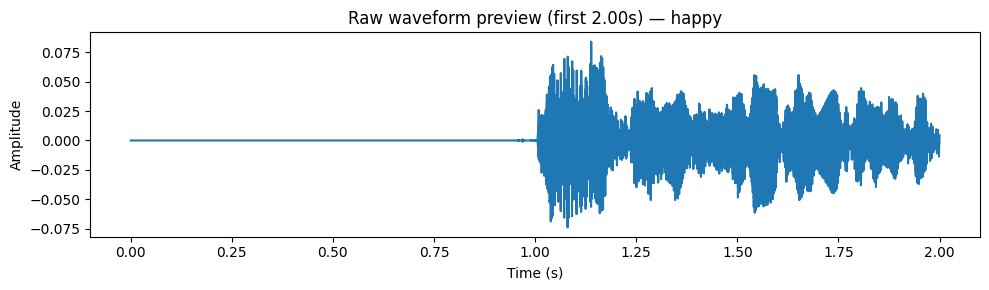


### Emotion: neutral
────────────────────────────────────────────────────────────────────────
RAW AUDIO SUMMARY
────────────────────────────────────────────────────────────────────────
File:                /content/data/speech_emotion_ravdess_tess_crema/RAVDESS/Actor_17/03-01-01-01-02-01-17.wav
File size:           378.5 KB
Sample rate (Hz):    48000
Channels:            1  (mono)
Samples / channel:   168,168
Duration:            3.503 sec  (00:04)
Max amplitude:       0.0684 (min)  |  0.0953 (|max|)
Mean amplitude:      -0.0000  (DC offset check)
Clipping (>=0.999):  0.000% of samples
────────────────────────────────────────────────────────────────────────


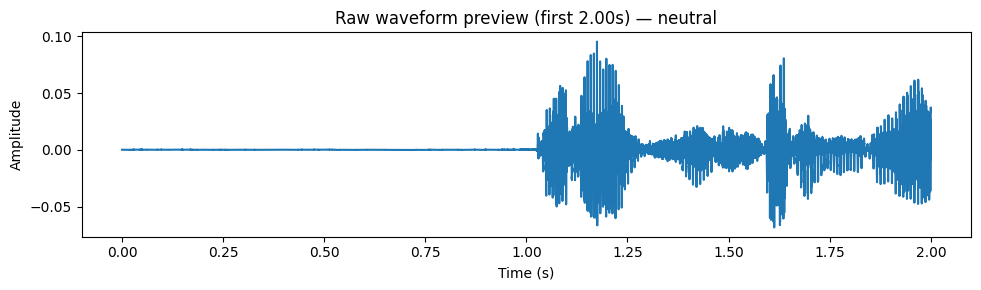


### Emotion: sad
────────────────────────────────────────────────────────────────────────
RAW AUDIO SUMMARY
────────────────────────────────────────────────────────────────────────
File:                /content/data/speech_emotion_ravdess_tess_crema/RAVDESS/Actor_18/03-01-04-02-02-01-18.wav
File size:           446.2 KB
Sample rate (Hz):    48000
Channels:            1  (mono)
Samples / channel:   198,599
Duration:            4.137 sec  (00:04)
Max amplitude:       0.3070 (min)  |  0.3246 (|max|)
Mean amplitude:      -0.0000  (DC offset check)
Clipping (>=0.999):  0.000% of samples
────────────────────────────────────────────────────────────────────────


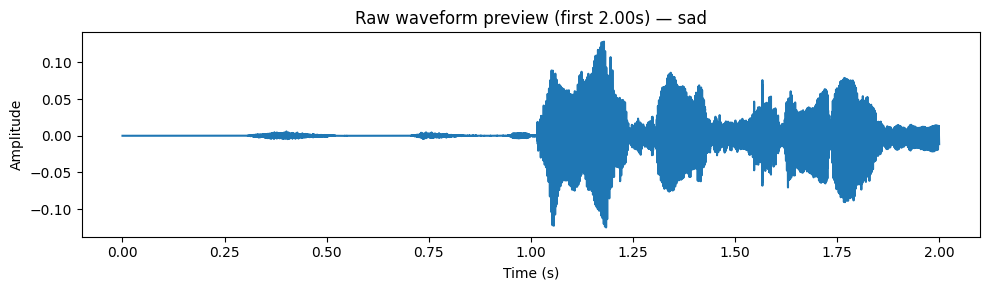


### Emotion: surprise
────────────────────────────────────────────────────────────────────────
RAW AUDIO SUMMARY
────────────────────────────────────────────────────────────────────────
File:                /content/data/speech_emotion_ravdess_tess_crema/RAVDESS/Actor_14/03-01-08-02-02-01-14.wav
File size:           406.8 KB
Sample rate (Hz):    48000
Channels:            1  (mono)
Samples / channel:   177,778
Duration:            3.704 sec  (00:04)
Max amplitude:       0.0578 (min)  |  0.0609 (|max|)
Mean amplitude:      0.0000  (DC offset check)
Clipping (>=0.999):  0.000% of samples
────────────────────────────────────────────────────────────────────────


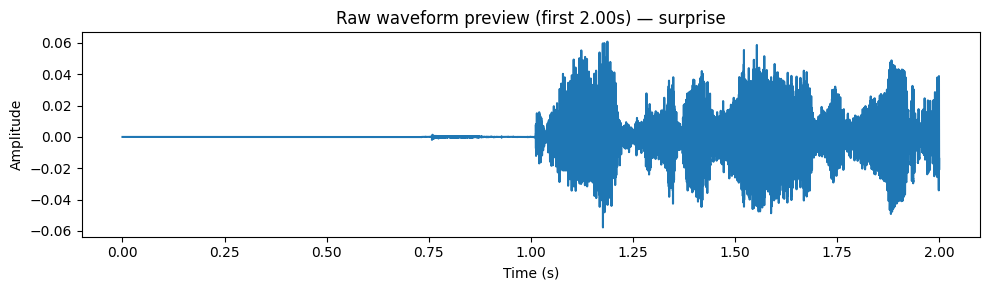

CREMA-D — one raw sample per emotion

### Emotion: angry
────────────────────────────────────────────────────────────────────────
RAW AUDIO SUMMARY
────────────────────────────────────────────────────────────────────────
File:                /content/data/speech_emotion_ravdess_tess_crema/CREMA/AudioWAV/1038_WSI_ANG_XX.wav
File size:           91.8 KB
Sample rate (Hz):    16000
Channels:            1  (mono)
Samples / channel:   46,980
Duration:            2.936 sec  (00:03)
Max amplitude:       1.0000 (min)  |  1.0000 (|max|)
Mean amplitude:      -0.0000  (DC offset check)
Clipping (>=0.999):  0.002% of samples
────────────────────────────────────────────────────────────────────────


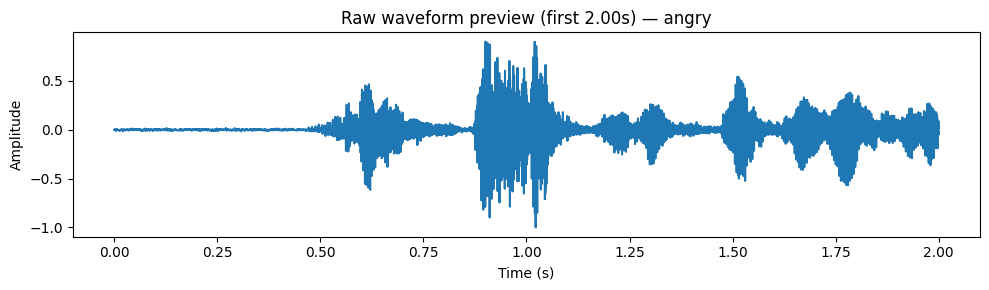


### Emotion: disgust
────────────────────────────────────────────────────────────────────────
RAW AUDIO SUMMARY
────────────────────────────────────────────────────────────────────────
File:                /content/data/speech_emotion_ravdess_tess_crema/CREMA/AudioWAV/1077_MTI_DIS_XX.wav
File size:           76.2 KB
Sample rate (Hz):    16000
Channels:            1  (mono)
Samples / channel:   38,972
Duration:            2.436 sec  (00:02)
Max amplitude:       0.2858 (min)  |  0.3033 (|max|)
Mean amplitude:      -0.0000  (DC offset check)
Clipping (>=0.999):  0.000% of samples
────────────────────────────────────────────────────────────────────────


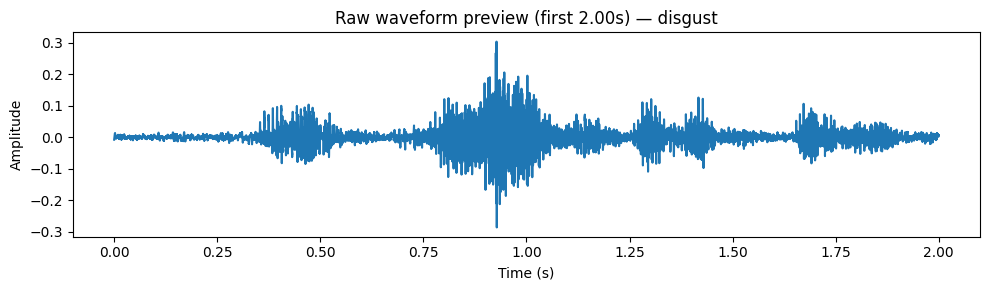


### Emotion: fear
────────────────────────────────────────────────────────────────────────
RAW AUDIO SUMMARY
────────────────────────────────────────────────────────────────────────
File:                /content/data/speech_emotion_ravdess_tess_crema/CREMA/AudioWAV/1057_TSI_FEA_XX.wav
File size:           82.4 KB
Sample rate (Hz):    16000
Channels:            1  (mono)
Samples / channel:   42,175
Duration:            2.636 sec  (00:03)
Max amplitude:       0.5134 (min)  |  0.5134 (|max|)
Mean amplitude:      -0.0000  (DC offset check)
Clipping (>=0.999):  0.000% of samples
────────────────────────────────────────────────────────────────────────


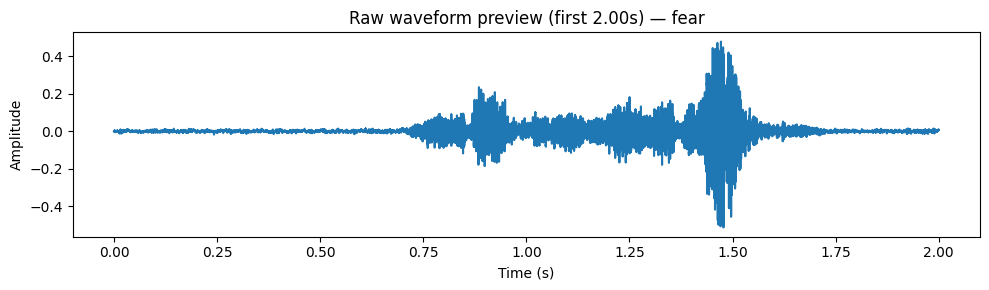


### Emotion: happy
────────────────────────────────────────────────────────────────────────
RAW AUDIO SUMMARY
────────────────────────────────────────────────────────────────────────
File:                /content/data/speech_emotion_ravdess_tess_crema/CREMA/AudioWAV/1055_IEO_HAP_HI.wav
File size:           55.3 KB
Sample rate (Hz):    16000
Channels:            1  (mono)
Samples / channel:   28,295
Duration:            1.768 sec  (00:02)
Max amplitude:       0.1363 (min)  |  0.1363 (|max|)
Mean amplitude:      0.0000  (DC offset check)
Clipping (>=0.999):  0.000% of samples
────────────────────────────────────────────────────────────────────────


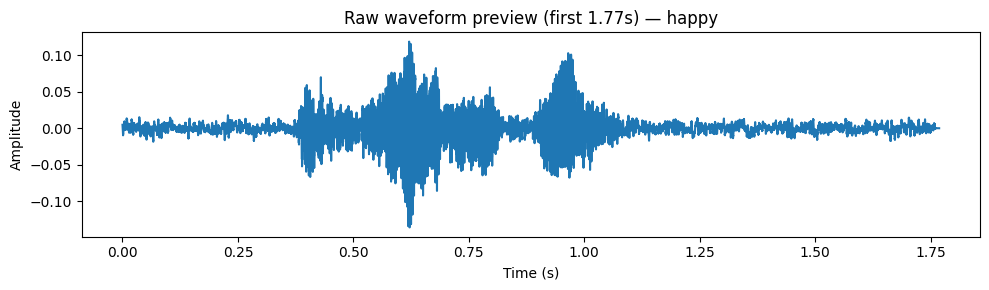


### Emotion: neutral
────────────────────────────────────────────────────────────────────────
RAW AUDIO SUMMARY
────────────────────────────────────────────────────────────────────────
File:                /content/data/speech_emotion_ravdess_tess_crema/CREMA/AudioWAV/1012_IWL_NEU_XX.wav
File size:           82.4 KB
Sample rate (Hz):    16000
Channels:            1  (mono)
Samples / channel:   42,175
Duration:            2.636 sec  (00:03)
Max amplitude:       0.1414 (min)  |  0.1414 (|max|)
Mean amplitude:      -0.0000  (DC offset check)
Clipping (>=0.999):  0.000% of samples
────────────────────────────────────────────────────────────────────────


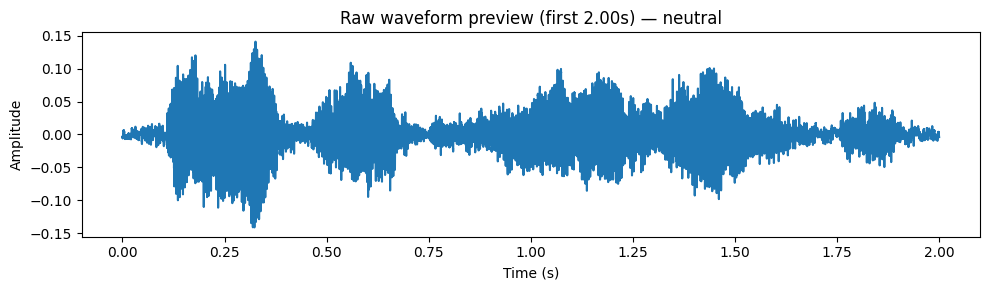


### Emotion: sad
────────────────────────────────────────────────────────────────────────
RAW AUDIO SUMMARY
────────────────────────────────────────────────────────────────────────
File:                /content/data/speech_emotion_ravdess_tess_crema/CREMA/AudioWAV/1064_IOM_SAD_XX.wav
File size:           84.5 KB
Sample rate (Hz):    16000
Channels:            1  (mono)
Samples / channel:   43,243
Duration:            2.703 sec  (00:03)
Max amplitude:       0.0410 (min)  |  0.0515 (|max|)
Mean amplitude:      -0.0001  (DC offset check)
Clipping (>=0.999):  0.000% of samples
────────────────────────────────────────────────────────────────────────


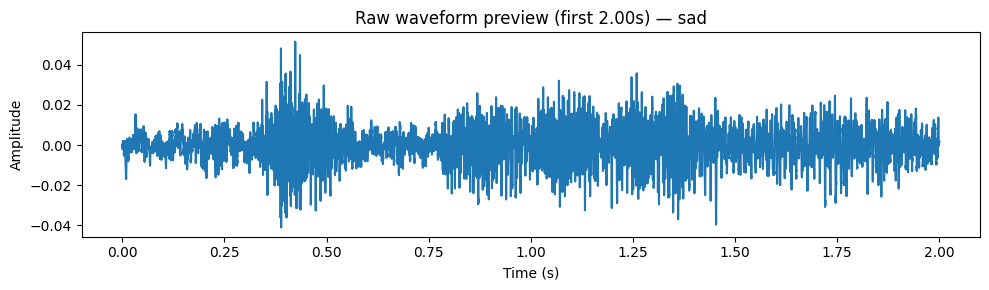

In [11]:
def print_step_header(header_text):
    print(header_text)

# === 1. RAW LOAD (MULTI-SAMPLE VIEW, NO CLEANING) ===
print_step_header("STEP 1 — RAW LOAD (EDA - MULTI-SAMPLE VIEW)")

# Modified show_raw_samples to remove extra newlines before header
def show_raw_samples(samples, seconds_preview=2.0, header=""):
    if header:
        print("="*80)
        print(f"{header}")
        print("="*80)
    for emo, path in samples:
        print(f"\n### Emotion: {emo}")
        y, sr = load_raw(path)
        summarize_raw(y, sr, path)
        preview_waveform(y, sr, seconds=seconds_preview, title_extra=f" — {emo}")

random.seed(7)

# ---------- utilities you already have ----------
def load_raw(path):
    y, sr = librosa.load(path, sr=None, mono=False)
    return y, sr

def _hms(seconds: float) -> str:
    m, s = divmod(int(round(seconds)), 60)
    return f"{m:02d}:{s:02d}"

def summarize_raw(y, sr, path):
    if y.ndim == 2:
        channels = y.shape[0]; samples_per_ch = y.shape[1]
        dur = samples_per_ch / sr if sr else 0.0
        flat = y.reshape(-1)
        pcm  = [float(np.max(np.abs(y[c]))) for c in range(channels)]
        pmin = [float(np.min(y[c])) for c in range(channels)]
        pmean= [float(np.mean(y[c])) for c in range(channels)]
    else:
        channels = 1; samples_per_ch = y.shape[0]
        dur = samples_per_ch / sr if sr else 0.0
        flat = y
        pcm  = [float(np.max(np.abs(y)))]; pmin = [float(np.min(y))]; pmean = [float(np.mean(y))]

    try: fsize = os.path.getsize(path)
    except OSError: fsize = None

    clip_pct = 100.0 * float(np.mean(np.abs(flat) >= 0.999)) if flat.size else 0.0
    def _fmt(vals): return ", ".join([f"{v:.4f}" for v in vals])

    print("─"*72)
    print("RAW AUDIO SUMMARY")
    print("─"*72)
    print(f"File:                {path}")
    if fsize is not None: print(f"File size:           {fsize/1024:.1f} KB")
    print(f"Sample rate (Hz):    {sr}")
    print(f"Channels:            {channels}  ({'stereo' if channels==2 else 'mono'})")
    print(f"Samples / channel:   {samples_per_ch:,}")
    print(f"Duration:            {dur:.3f} sec  ({_hms(dur)})")
    print(f"Max amplitude:       {_fmt([abs(v) for v in pmin])} (min)  |  {_fmt(pcm)} (|max|)")
    print(f"Mean amplitude:      {_fmt(pmean)}  (DC offset check)")
    print(f"Clipping (>=0.999):  {clip_pct:.3f}% of samples")
    print("─"*72)

def preview_waveform(y, sr, seconds=2.0, title_extra=""):
    y_plot = librosa.to_mono(y) if y.ndim == 2 else y
    n = min(len(y_plot), int(seconds * sr))
    if n <= 0:
        print("Nothing to plot."); return
    plt.figure(figsize=(10, 3))
    plt.plot(np.arange(n) / sr, y_plot[:n])
    plt.xlabel("Time (s)"); plt.ylabel("Amplitude")
    plt.title(f"Raw waveform preview (first {min(seconds, n/sr):.2f}s){title_extra}")
    plt.tight_layout(); plt.show()

# --- PATH & CODEBOOK SETUP ---
# Re-define path to CREMA-D audio files to ensure this cell is self-contained
CREMA_AUDIO_DIR = os.path.join(CREMA_DIR, "AudioWAV")

TESS_EMOTIONS = [
    "angry", "disgust", "fear", "happy", "neutral", "pleasant_surprise", "sad"
]

RAVDESS_EMO_MAP = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fear", "07": "disgust", "08": "surprise"
}

# Add CREMA-D codebook, used by the new function below
CREMA_EMO_MAP = {
    'ANG': 'angry', 'DIS': 'disgust', 'FEA': 'fear',
    'HAP': 'happy', 'NEU': 'neutral', 'SAD': 'sad'
}

# --- FILE LISTING FUNCTIONS ---
def list_tess_by_emotion():
    # ... (this function is unchanged)
    emo_dict = {e: [] for e in TESS_EMOTIONS}
    for emo in TESS_EMOTIONS:
        for actor_folder in ["OAF", "YAF"]:
             patt = os.path.join(TESS_DIR, f"{actor_folder}_{emo}", "*.wav")
             emo_dict[emo].extend(glob.glob(patt))
    return {k: v for k, v in emo_dict.items() if v}

def list_ravdess_by_emotion():
    # ... (this function is unchanged)
    emo_dict = {e: [] for e in set(RAVDESS_EMO_MAP.values())}
    wavs = glob.glob(os.path.join(RAVDESS_DIR, "Actor_*", "*.wav"))
    for p in wavs:
        base = os.path.basename(p)
        parts = base.split('-')
        if len(parts) >= 3:
            code = parts[2]
            emo = RAVDESS_EMO_MAP.get(code)
            if emo: emo_dict[emo].append(p)
    return {k: v for k, v in emo_dict.items() if v}

# ADDED FOR CREMA-D
def list_crema_by_emotion():
    """Groups CREMA-D file paths by emotion using its codebook."""
    emo_dict = {e: [] for e in set(CREMA_EMO_MAP.values())}
    wavs = glob.glob(os.path.join(CREMA_AUDIO_DIR, "*.wav"))
    for p in wavs:
        base = os.path.basename(p)
        # Filename: 1001_DFA_ANG_XX.wav -> Emotion code is the 3rd part
        parts = base.split('_')
        if len(parts) >= 3:
            code = parts[2]
            emo = CREMA_EMO_MAP.get(code)
            if emo:
                emo_dict[emo].append(p)
    return {k: v for k, v in emo_dict.items() if v}

# --- SAMPLING & EXECUTION ---
def sample_per_emotion(file_dict, per_emotion=1):
    # ... (this function is unchanged)
    picks = []
    for emo, files in sorted(file_dict.items()):
        if not files: continue
        take = min(per_emotion, len(files))
        picks.extend([(emo, f) for f in random.sample(files, take)])
    return picks

# ===== Run: one sample per emotion from each dataset =====
tess_files = list_tess_by_emotion()
rav_files  = list_ravdess_by_emotion()
crema_files = list_crema_by_emotion() # ADDED

tess_samples = sample_per_emotion(tess_files, per_emotion=1)
rav_samples  = sample_per_emotion(rav_files,  per_emotion=1)
crema_samples = sample_per_emotion(crema_files, per_emotion=1) # ADDED

show_raw_samples(tess_samples, seconds_preview=2.0, header="TESS DATASET — one raw sample per emotion")
show_raw_samples(rav_samples,  seconds_preview=2.0, header="RAVDESS — one raw sample per emotion")
show_raw_samples(crema_samples, seconds_preview=2.0, header="CREMA-D — one raw sample per emotion") # ADDED

•  If mean is far from 0, then will need DC offset removal<p>
•  If max amplitude << 1.0, normalization will help<p>
•  Clipping > 0% suggests the waveform may be saturated.

**What’s DC offset?**

> Audio waveforms ideally oscillate evenly around 0 amplitude (center line in the waveform plot).
> Sometimes, due to recording hardware, electrical interference, or processing errors, the entire signal is shifted up or down.
> This shift is called a DC (Direct Current) offset, because it’s like a constant “voltage bias” added to the whole waveform.

Example:
```
Correct signal: -1.0 ... 0.0 ... +1.0
With DC offset: -0.8 ... +0.2 ... +1.2   (centered around +0.2 instead of 0.0)
```

**Why is it a problem?**<p>
**Wasted headroom:** The offset pushes part of the signal closer to clipping.

**Distortion risk:** Boosting/normalizing a biased signal may clip the positive or negative peaks.

**Inaccurate analysis:** Many audio features (RMS, spectral analysis) assume zero-centered data.

**Audio File Diagnostics**
The purpose of this script is to analyze the technical properties of a single audio file. It identifies potential quality issues and generates a report with specific recommendations for preprocessing steps. The process is handled by three main functions:


*   dataset_profile(path): This function first identifies the source dataset (TESS, RAVDESS, or CREMA-D) by inspecting the input file path. It then returns a profile containing standard parameters for that dataset, such as the target sample rate (e.g., 22050 Hz) and an expected duration range.
*   audio_stats(...): This function takes the raw audio data and calculates a dictionary of key technical metrics. These metrics include the sample rate, duration, peak amplitude, RMS (Root Mean Square) level for loudness, mean amplitude (to check for DC offset), and the amount of leading/trailing silence.
*   print_stats(...): It compares the actual metrics calculated by audio_stats against the standard parameters defined in dataset_profile. Based on this comparison, it prints a summary with explicit recommendations for cleaning actions, such as whether to resample, normalize, or trim the audio file.









STEP 2 — DIAGNOSTICS ON SAMPLE DATA
File: /content/drive/MyDrive/multiclassproject/TESS Toronto emotional speech set data/OAF_angry/OAF_voice_angry.wav

BEFORE CLEANING (RAW)
Sample rate (Hz)         : 24414 → resample to 22050 Hz for TESS consistency.


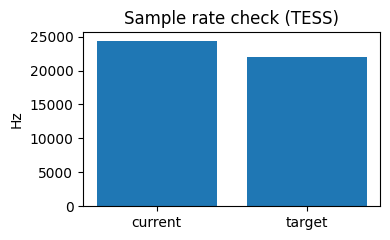

Duration (sec)           : 1.589 → OK (within typical TESS range 1.20–2.50s).
Peak amplitude           : 0.1522 → quiet; normalize up to target peak ≈ 0.95.
RMS (dB)                 : -31.20 → very quiet; gain-up likely needed.
Mean amplitude           : -0.0000 → centered near zero.
Leading silence (ms)     : 62 → trim recommended.
Trailing silence (ms)    : 246 → trim recommended.
Clipping (%)             : 0.000 → low.


In [12]:
# ---- plain text step header (no borders, no colors)
def print_step_header(step_number, description):
    print(f"STEP {step_number} — {description}")

# === STEP 2 (with CREMA-D profile) ===
print_step_header(2, "DIAGNOSTICS ON SAMPLE DATA")

# ---- dataset-aware profile (targets & typical duration ranges) ----
def dataset_profile(path):
    p = path.lower()
    # Defaults if unknown
    profile = {
        "name": "dataset",
        "target_sr": 22050,
        "dur_range": (1.0, 4.0)  # seconds
    }
    if "tess" in p:
        profile.update({"name": "TESS", "target_sr": 22050, "dur_range": (1.2, 2.5)})
    elif "ravdess" in p or "actor_" in p:
        profile.update({"name": "RAVDESS", "target_sr": 22050, "dur_range": (2.5, 4.0)})
    # ADDED FOR CREMA-D
    elif "crema" in p:
        profile.update({"name": "CREMA-D", "target_sr": 22050, "dur_range": (1.5, 3.5)})
    return profile

def audio_stats(y, sr, trim_db=20):
    """Diagnostics only — no cleaning applied."""
    y_mono = librosa.to_mono(y) if y.ndim == 2 else y
    dur = len(y_mono) / sr if sr else 0.0
    peak = float(np.max(np.abs(y_mono))) if y_mono.size else 0.0
    mean_amp = float(np.mean(y_mono)) if y_mono.size else 0.0
    rms = float(np.sqrt(np.mean(y_mono**2))) if y_mono.size else 0.0
    rms_db = 20 * np.log10(rms + 1e-12)
    _, idx = librosa.effects.trim(y_mono, top_db=trim_db)
    lead_ms = (idx[0] / sr) * 1000
    trail_ms = ((len(y_mono) - idx[1]) / sr) * 1000
    clip_pct = 100.0 * float(np.mean(np.abs(y_mono) >= 0.999)) if y_mono.size else 0.0
    return {
        "Sample rate (Hz)": sr, "Duration (sec)": round(dur, 3),
        "Peak amplitude": round(peak, 4), "RMS (dB)": round(rms_db, 2),
        "Mean amplitude": round(mean_amp, 4), "Leading silence (ms)": int(lead_ms),
        "Trailing silence (ms)": int(trail_ms), "Clipping (%)": round(clip_pct, 3),
        "_y": y_mono, "_sr": sr
    }

def inspect_raw(path, trim_db=20):
    """Load file as-is and return diagnostics."""
    y, sr = librosa.load(path, sr=None, mono=False)
    return audio_stats(y, sr, trim_db=trim_db)

# --- helper: conditional figures ---
def _plot_sr_if_needed(sr, target_sr, title_suffix=""):
    if sr == target_sr: return
    plt.figure(figsize=(4, 2.5)); plt.bar(["current", "target"], [sr, target_sr])
    plt.title(f"Sample rate check {title_suffix}"); plt.ylabel("Hz")
    plt.tight_layout(); plt.show()

def _plot_duration_if_outside(dur, lo, hi, title_suffix=""):
    if lo <= dur <= hi: return
    plt.figure(figsize=(5.5, 2.5)); plt.bar(["duration"], [dur])
    plt.hlines([lo, hi], xmin=-0.5, xmax=0.5, linestyles=["dashed","dashed"])
    plt.text(0.55, lo, f"lo={lo:.2f}s", va="center"); plt.text(0.55, hi, f"hi={hi:.2f}s", va="center")
    plt.title(f"Duration vs typical range {title_suffix}"); plt.ylabel("seconds")
    plt.tight_layout(); plt.show()

def print_stats(stats_dict, title="Diagnostics", path_for_context=None):
    prof = dataset_profile(path_for_context or "")
    sr, dur, peak, rmsdb, mean, lead, trail, clip = (
        stats_dict["Sample rate (Hz)"], stats_dict["Duration (sec)"],
        stats_dict["Peak amplitude"], stats_dict["RMS (dB)"],
        stats_dict["Mean amplitude"], stats_dict["Leading silence (ms)"],
        stats_dict["Trailing silence (ms)"], stats_dict["Clipping (%)"]
    )
    print("\n" + title)
    need = f"→ resample to {prof['target_sr']} Hz for {prof['name']} consistency." if sr != prof['target_sr'] else "→ OK (matches target)."
    print(f"{'Sample rate (Hz)':<25}: {sr} {need}")
    _plot_sr_if_needed(sr, prof['target_sr'], title_suffix=f"({prof['name']})")
    lo, hi = prof["dur_range"]
    if dur < lo: dmsg = f"→ shorter than typical {prof['name']} range {lo:.2f}–{hi:.2f}s."
    elif dur > hi: dmsg = f"→ longer than typical {prof['name']} range {lo:.2f}–{hi:.2f}s."
    else: dmsg = f"→ OK (within typical {prof['name']} range {lo:.2f}–{hi:.2f}s)."
    print(f"{'Duration (sec)':<25}: {dur:.3f} {dmsg}")
    _plot_duration_if_outside(dur, lo, hi, title_suffix=f"({prof['name']})")
    if peak >= 0.99 or clip > 0.1: pmsg = "→ TOO HOT / likely clipping; normalize down or limit."
    elif peak <= 0.65: pmsg = "→ quiet; normalize up to target peak ≈ 0.95."
    else: pmsg = "→ reasonable; normalization optional."
    print(f"{'Peak amplitude':<25}: {peak:.4f} {pmsg}")
    if rmsdb < -30: rmsg = "→ very quiet; gain-up likely needed."
    elif rmsdb > -12: rmsg = "→ loud; verify no distortion."
    else: rmsg = "→ typical dialog range."
    print(f"{'RMS (dB)':<25}: {rmsdb:.2f} {rmsg}")
    if abs(mean) > 0.02: mmsg = "→ DC offset suspected; apply high-pass/DC removal."
    else: mmsg = "→ centered near zero."
    print(f"{'Mean amplitude':<25}: {mean:.4f} {mmsg}")
    s_thresh = 50  # ms
    lmsg = "→ trim recommended." if lead > s_thresh else "→ minimal."
    tmsg = "→ trim recommended." if trail > s_thresh else "→ minimal."
    print(f"{'Leading silence (ms)':<25}: {lead} {lmsg}")
    print(f"{'Trailing silence (ms)':<25}: {trail} {tmsg}")
    cmsg = "→ high; review peaks or re-record." if clip > 0.1 else "→ low."
    print(f"{'Clipping (%)':<25}: {clip:.3f} {cmsg}")

# ----- DEMO on one fixed file -----
# This path is unchanged, as you requested.
example_path = "/content/drive/MyDrive/multiclassproject/TESS Toronto emotional speech set data/OAF_angry/OAF_voice_angry.wav"

# Safety check
import os
assert os.path.exists(example_path), f"File not found: {example_path}"

# Run diagnostics
raw_stats = inspect_raw(example_path, trim_db=20)
print(f"File: {example_path}")
print_stats(raw_stats, title="BEFORE CLEANING (RAW)", path_for_context=example_path)

<H1>EXPLANATION OF RESULTS</H1>

**Duration (sec): 1.589** – The clip length is within the typical TESS dataset range of 1.20–2.50 seconds, so no trimming or padding is necessary.
---
**Peak amplitude: 0.1522** – The loudest point in the audio reaches about 15.2% of the maximum possible digital amplitude, which is quiet. It can be normalized up to a target peak of around 0.95 to increase volume without distortion.
---
<b>RMS (dB): -31.20 dB </b>– This is the average loudness level of the clip. It is quieter than the typical dialog range (around -30 to -12 dB), so a gain boost will help for better audibility.
---
<b>Mean amplitude: -0.0000 </b>– The average amplitude across the clip is  zero, indicating no DC offset and a waveform centered properly.
---
**Leading silence (ms): 62 ms** – A short pause exists at the start of the clip. Trimming can help align data for more consistent processing and training.
---
**Trailing silence (ms): 246 ms** – There’s a longer pause at the end of the clip. Trimming is recommended to remove unnecessary silence that does not contribute to the signal.
---
<b>Clipping (%): 0.000</b> – No samples exceed the maximum amplitude, so there’s no distortion from clipping.
--



# **Which files needed cleaning for the entire dataset?**

<h2>THRESHOLDS</h2>
<p><b>TARGET_SR = 22050</b></p>
A common speech/audio standard in librosa tutorials. It halves 44.1k/48k audio while keeping energy up to ~11 kHz (speech is mostly <8 kHz). It makes TESS (≈24.4k) and RAVDESS (48k) consistent and cheaper to process.

<p><b>TRIM_DB = 20</p></b>
Used by librosa.effects.trim as “keep anything within 20 dB of the peak.” It’s a conservative silence trim that won’t chop quiet consonants/breaths. (30 dB is more aggressive; 10 dB is gentler.)

<p><b>PEAK_MIN_FOR_OK = 0.90</p></b>
If the file’s peak amplitude is <0.9 (on the -1..1 scale), we normalize. It’s a simple trigger to get peaks close to full scale without overreacting to tiny headroom differences.

<p><b>ABS_MEAN_MAX_OK = 0.01</p></b>
DC-offset check. |mean| > 0.01 (≈ -40 dB) is a noticeable bias; we recentre. Smaller offsets are usually negligible.

<p><b>SILENCE_MS_OK = 100</p></b>
If leading or trailing silence >100 ms, we trim. ~0.1 s is audible dead air but short enough to keep natural pauses.

<p><b>CLIP_PCT_OK = 0.1</p></b>
If ≥0.1% of samples hit |x|≥0.999, we flag clipping (saturation risk). Anything non-zero is suspicious; 0.1% avoids false positives from single spikes.

<p><b> DUR_RANGE_OK = (1.0, 4.0)</p></b>
Typical utterance length in TESS/RAVDESS sits ~1–3 s. Using 1–4 s catches outliers (too short/long) without being harsh.

In [13]:
# --- config (thresholds) ---
TARGET_SR = 22050
TRIM_DB   = 20
PEAK_MIN_FOR_OK = 0.90
ABS_MEAN_MAX_OK = 0.01
SILENCE_MS_OK   = 100
CLIP_PCT_OK     = 0.1
DUR_RANGE_OK    = (1.0, 4.0)


# ---- Minimal audio processing functions ----
def _audio_stats_min(y, sr, trim_db=TRIM_DB):
    y_mono = librosa.to_mono(y) if y.ndim == 2 else y
    dur = len(y_mono)/sr if sr else 0.0
    peak = float(np.max(np.abs(y_mono))) if y_mono.size else 0.0
    mean_amp = float(np.mean(y_mono)) if y_mono.size else 0.0
    rms = float(np.sqrt(np.mean(y_mono**2))) if y_mono.size else 0.0
    rms_db = 20*np.log10(rms + 1e-12)
    _, idx = librosa.effects.trim(y_mono, top_db=trim_db)
    lead_ms  = (idx[0] / sr) * 1000
    trail_ms = ((len(y_mono) - idx[1]) / sr) * 1000
    clip_pct = 100.0 * float(np.mean(np.abs(y_mono) >= 0.999)) if y_mono.size else 0.0
    return {
        "sr": sr, "duration_sec": round(dur,3), "peak_amp": round(peak,4),
        "rms_db": round(rms_db,2), "mean_amp": round(mean_amp,4),
        "leading_silence_ms": int(lead_ms), "trailing_silence_ms": int(trail_ms),
        "clipping_pct": round(clip_pct,3)
    }

def audio_stats(y, sr, trim_db=TRIM_DB):
    return _audio_stats_min(y, sr, trim_db)

def inspect_raw(path, trim_db=TRIM_DB):
    y, sr = librosa.load(path, sr=None, mono=False)
    return audio_stats(y, sr, trim_db=trim_db)

# ---- Build manifest if missing ----

# --- Define paths and codebooks needed to build the manifest ---
CREMA_AUDIO_DIR = os.path.join(CREMA_DIR, "AudioWAV")
TESS_EMOTIONS = ["angry","disgust","fear","happy","neutral","pleasant_surprise","sad"]
RAVDESS_EMO_MAP = {"01":"neutral","02":"calm","03":"happy","04":"sad","05":"angry","06":"fear","07":"disgust","08":"surprise"}
CREMA_EMO_MAP = {'ANG': 'angry', 'DIS': 'disgust', 'FEA': 'fear', 'HAP': 'happy', 'NEU': 'neutral', 'SAD': 'sad'}

def list_tess_files():
    rows = []
    for emo in TESS_EMOTIONS:
        for actor_folder in ["OAF", "YAF"]:
            patt = os.path.join(TESS_DIR, f"{actor_folder}_{emo}", "*.wav")
            rows.extend([{"dataset":"TESS","emotion":emo,"path":p} for p in glob.glob(patt)])
    return rows

def list_ravdess_files():
    rows = []
    for p in glob.glob(os.path.join(RAVDESS_DIR, "Actor_*", "*.wav")):
        base = os.path.basename(p).split('-')
        if len(base) >= 3:
            emo = RAVDESS_EMO_MAP.get(base[2])
            if emo: rows.append({"dataset":"RAVDESS","emotion":emo,"path":p})
    return rows

# ADDED FOR CREMA-D
def list_crema_files():
    rows = []
    for p in glob.glob(os.path.join(CREMA_AUDIO_DIR, "*.wav")):
        base = os.path.basename(p).split('_')
        if len(base) >= 3:
            emo = CREMA_EMO_MAP.get(base[2])
            if emo: rows.append({"dataset":"CREMA-D","emotion":emo,"path":p})
    return rows


if 'eda_flags' not in globals():
    # MODIFIED to include CREMA-D
    manifest_list = list_tess_files() + list_ravdess_files() + list_crema_files()
    manifest = pd.DataFrame(manifest_list)
    print(f"Building eda_flags from manifest of {len(manifest)} files...")

    rows = []
    dur_lo, dur_hi = DUR_RANGE_OK
    # The tqdm library adds a progress bar, which is helpful for long processes
    from tqdm.auto import tqdm
    for _, r in tqdm(manifest.iterrows(), total=len(manifest)):
        try:
            s = inspect_raw(r["path"], trim_db=TRIM_DB)
            s.update(r)
            s["needs_resample"] = (s["sr"] != TARGET_SR)
            s["needs_normalize"] = (s["peak_amp"] < PEAK_MIN_FOR_OK)
            s["needs_dc_remove"] = (abs(s["mean_amp"]) > ABS_MEAN_MAX_OK)
            s["needs_trim"] = (s["leading_silence_ms"] > SILENCE_MS_OK) or (s["trailing_silence_ms"] > SILENCE_MS_OK)
            s["has_clipping"] = (s["clipping_pct"] >= CLIP_PCT_OK)
            s["duration_out_of_range"] = not (dur_lo <= s["duration_sec"] <= dur_hi)
            rows.append(s)
        except Exception as e:
            print(f"Error processing {r['path']}: {e}")


    eda_flags = pd.DataFrame(rows)
    print("eda_flags built:", eda_flags.shape)
else:
    print("eda_flags already exists:", eda_flags.shape)

Building eda_flags from manifest of 10882 files...


  0%|          | 0/10882 [00:00<?, ?it/s]

eda_flags built: (10882, 17)


--- DIAGNOSTICS SUMMARY TABLE ---
         needs_resample  needs_normalize  needs_dc_remove  needs_trim  has_clipping  duration_out_of_range  total_files
dataset                                                                                                                
CREMA-D            7442             6762                0        4185           246                     84         7442
RAVDESS            1440             1401                0        1440             0                    255         1440
TESS               2000             1987                0        1451             0                      0         2000


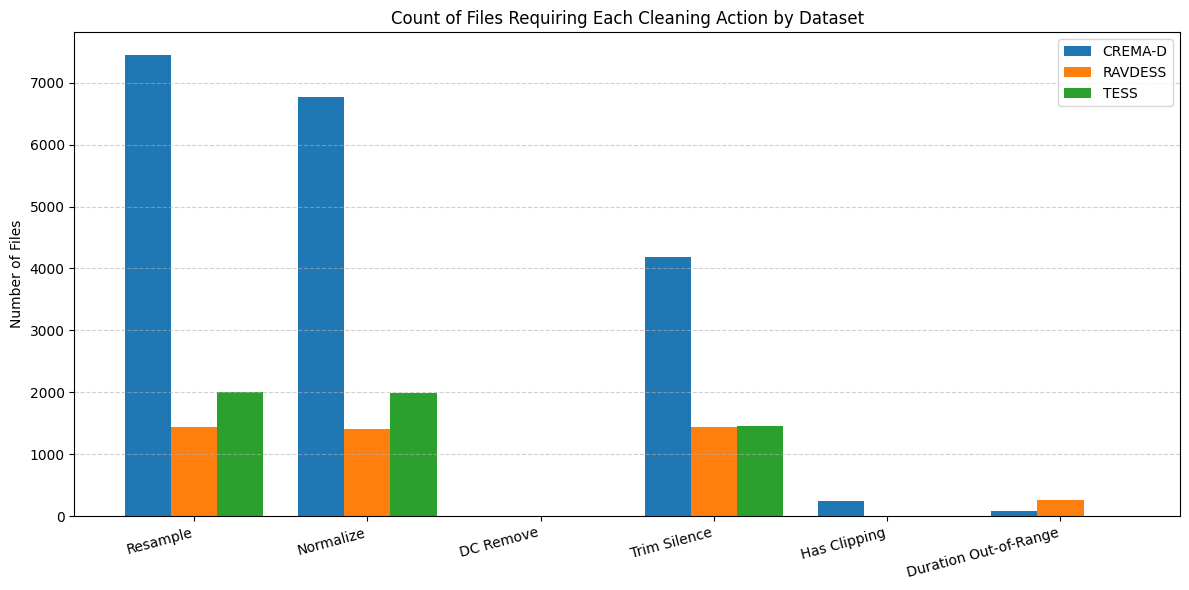

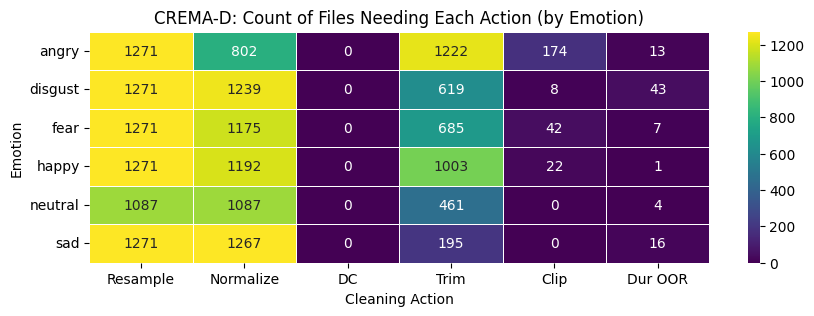

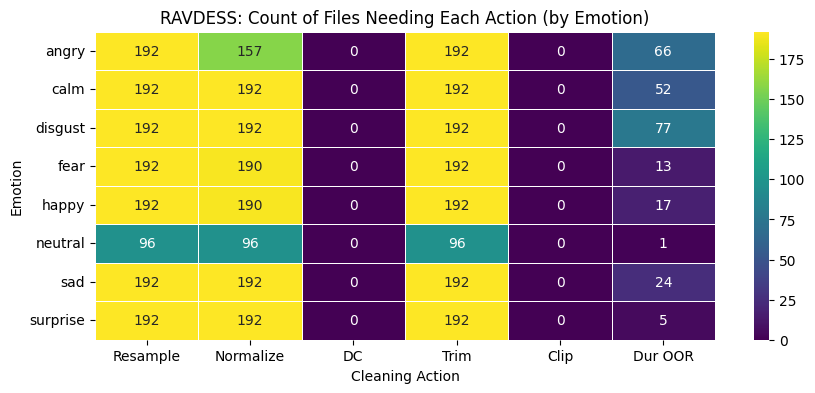

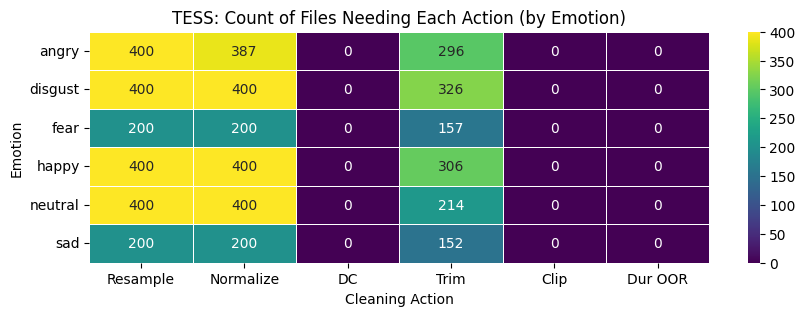

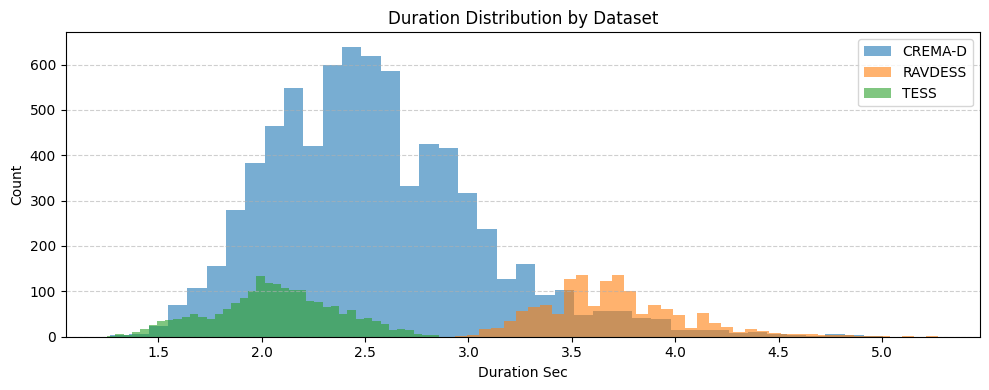

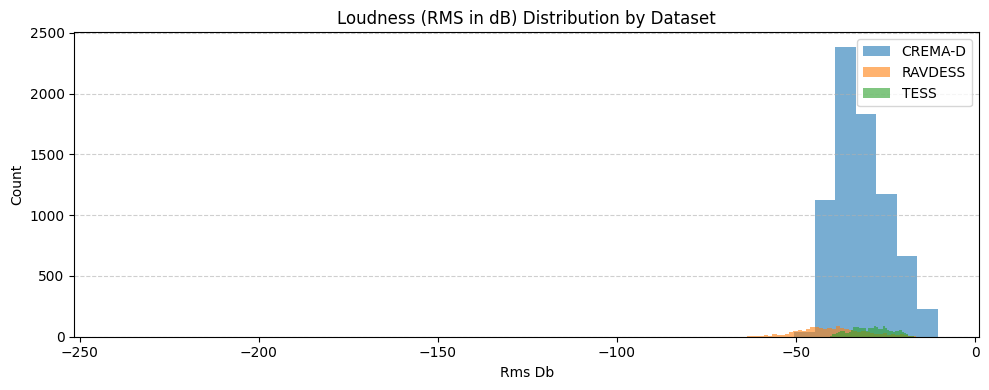

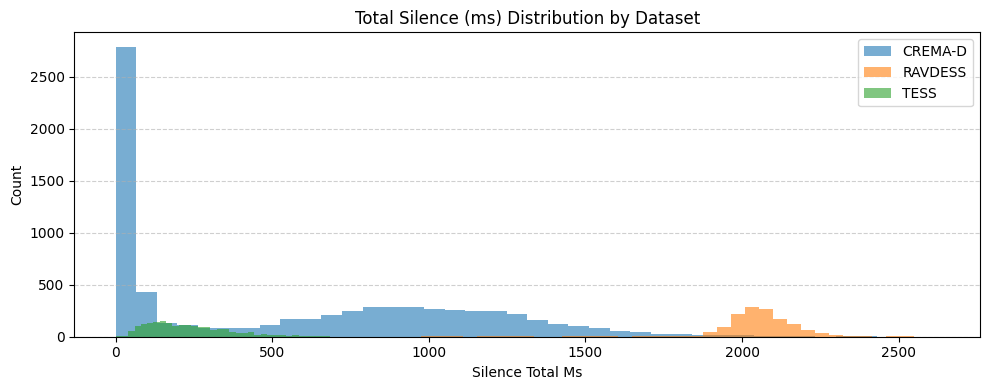

In [14]:

# Ensure the eda_flags DataFrame from the previous step exists
assert 'eda_flags' in globals(), "Please run the previous cell to build the 'eda_flags' DataFrame first."

# Define the flag columns we want to analyze
flag_cols = [
    "needs_resample",
    "needs_normalize",
    "needs_dc_remove",
    "needs_trim",
    "has_clipping",
    "duration_out_of_range",
]

# ---------- 1) Counts by dataset (table) ----------
print("--- DIAGNOSTICS SUMMARY TABLE ---")
by_dataset = (
    eda_flags.groupby("dataset")[flag_cols]
    .sum()
    .astype(int)
)
total_by_dataset = eda_flags.groupby("dataset")["path"].count().rename("total_files")
summary_table = by_dataset.join(total_by_dataset)
print(summary_table.to_string())


# ---------- 2) Grouped bar chart: Files needing each action (by dataset) ----------
datasets = summary_table.index.tolist()
n_datasets = len(datasets)
x = np.arange(len(flag_cols))
width = 0.8 / n_datasets  # Calculate bar width based on number of datasets

fig, ax = plt.subplots(figsize=(12, 6))

# Loop through datasets to plot bars side-by-side
for i, dataset in enumerate(datasets):
    offset = width * (i - (n_datasets - 1) / 2)
    values = summary_table.loc[dataset, flag_cols].values
    ax.bar(x + offset, values, width, label=dataset)

ax.set_xticks(x)
ax.set_xticklabels([
    "Resample", "Normalize", "DC Remove", "Trim Silence", "Has Clipping", "Duration Out-of-Range"
], rotation=15, ha="right")
ax.set_ylabel("Number of Files")
ax.set_title("Count of Files Requiring Each Cleaning Action by Dataset")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


# ---------- 3) Per-emotion heatmap view (counts) ----------
def per_emotion_matrix(df, dataset_name):
    df_ds = df[df["dataset"] == dataset_name]
    # Ensure 'emotion' column exists before grouping
    if 'emotion' not in df_ds.columns:
        print(f"Warning: 'emotion' column not found for {dataset_name}. Skipping heatmap.")
        return None
    mat = (
        df_ds.groupby("emotion")[flag_cols]
        .sum()
        .astype(int)
        .reindex(sorted(df_ds["emotion"].unique()))
    )
    return mat

for ds in summary_table.index:
    mat = per_emotion_matrix(eda_flags, ds)
    if mat is None or mat.empty:
        continue
    plt.figure(figsize=(10, 0.5 * len(mat)))
    sns.heatmap(mat, annot=True, fmt='d', cmap='viridis', linewidths=.5)
    plt.title(f"{ds}: Count of Files Needing Each Action (by Emotion)")
    plt.xlabel("Cleaning Action")
    plt.ylabel("Emotion")
    plt.xticks(ticks=np.arange(len(flag_cols)) + 0.5, labels=["Resample","Normalize","DC","Trim","Clip","Dur OOR"], rotation=0)
    plt.show()


# ---------- 4) Distributions of raw metrics to justify thresholds ----------
def hist_by_dataset(metric, bins=40, title=""):
    fig, ax = plt.subplots(figsize=(10,4))
    for ds, group in eda_flags.groupby("dataset"):
        ax.hist(group[metric].dropna(), bins=bins, alpha=0.6, label=ds)
    ax.set_title(title)
    ax.set_xlabel(metric.replace('_', ' ').title())
    ax.set_ylabel("Count")
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Calculate total silence for a more informative histogram
if "silence_total_ms" not in eda_flags.columns:
    eda_flags["silence_total_ms"] = eda_flags["leading_silence_ms"] + eda_flags["trailing_silence_ms"]

hist_by_dataset("duration_sec", title="Duration Distribution by Dataset")
hist_by_dataset("rms_db",       title="Loudness (RMS in dB) Distribution by Dataset")
hist_by_dataset("silence_total_ms", title="Total Silence (ms) Distribution by Dataset")

# <p>**The Strategy: A Two-Phase Cleaning Approach**</p>
**`Phase 1: Minimal Standardization `**<br>
This phase applies safe, global transformations that make the audio files technically uniform without altering the core spoken content.

Actions: Resampling to a common sample rate, converting to mono, and normalizing the peak volume.

Why it's "Minimal" and "Safe": These steps standardize the "container" of the audio. They ensure every file uses the same measurement scale (sample rate) and has a similar overall volume. This process doesn't remove any part of the actual recording, like a word or a pause. It is a required prerequisite for almost any feature extraction method.

**`Phase 2: Content-Aware Cleaning `** <br>
This next phase involves actions that can change the content of the audio and must be handled more carefully.

Actions: Trimming leading and trailing silence.


Trimming silence is a powerful way to focus the model on the relevant speech. However, if your trimming threshold is too aggressive, you risk cutting off a quiet consonant at the beginning of a word or a soft breath at the end. This would fundamentally damage the data.

**`Phase 1: Minimal Standardization`**
This code block defines a core preprocessing function, preprocess_audio, that applies safe, global transformations to every audio file. It then demonstrates the function's effect on a single sample file, showing a "before and after" comparison.

`**Key Actions:**`

**Resample:** Converts all audio to a single sample rate (22050 Hz).

**Convert to Mono:** Merges stereo channels into a single channel.

**Normalize Amplitude:** Adjusts the volume so that the loudest point is at a consistent level (95% of the maximum possible). This ensures all files have a similar volume.

PHASE 1: MINIMAL STANDARDIZATION, DEMONSTRATION on file: 03-01-01-01-01-01-01.wav

BEFORE STANDARDIZATION
Sample rate (Hz)         : 48000 → resample to 22050 Hz for TESS consistency.


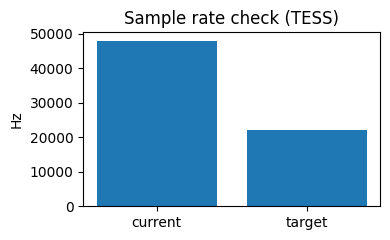

Duration (sec)           : 3.303 → longer than typical TESS range 1.20–2.50s.


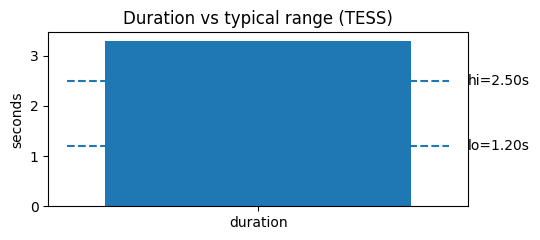

Peak amplitude           : 0.0406 → quiet; normalize up to target peak ≈ 0.95.
RMS (dB)                 : -47.96 → very quiet; gain-up likely needed.
Mean amplitude           : 0.0000 → centered near zero.
Leading silence (ms)     : 1034 → trim recommended.
Trailing silence (ms)    : 1073 → trim recommended.
Clipping (%)             : 0.000 → low.

AFTER STANDARDIZATION
Sample rate (Hz)         : 22050 → OK (matches target).
Duration (sec)           : 3.303 → longer than typical TESS range 1.20–2.50s.


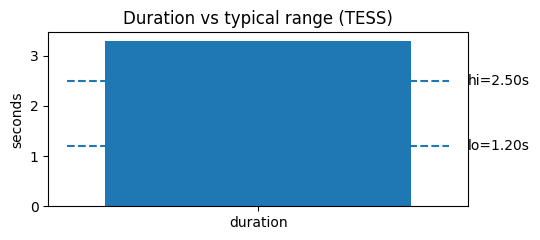

Peak amplitude           : 0.9500 → reasonable; normalization optional.
RMS (dB)                 : -20.66 → typical dialog range.
Mean amplitude           : 0.0000 → centered near zero.
Leading silence (ms)     : 1021 → trim recommended.
Trailing silence (ms)    : 1050 → trim recommended.
Clipping (%)             : 0.000 → low.

Waveform after standardization:


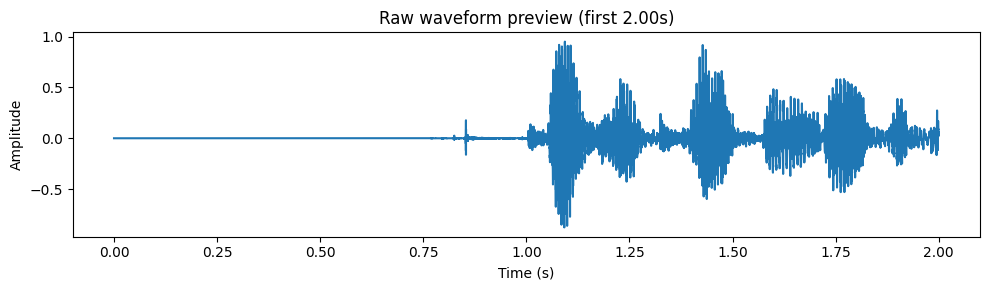

In [15]:
# --- Configuration for Standardization ---
TARGET_SR = 22050
TARGET_AMP = 0.95 # Normalize audio to 95% of the maximum amplitude

# --- Redefining Helper Functions for Consistency ---
# We redefine these functions here to ensure they return the long, descriptive keys
# that the print_stats() function (from a previous cell) expects. This resolves the KeyError.

def audio_stats(y, sr, trim_db=20):
    """Calculates diagnostics and returns a dictionary with full-text keys."""
    y_mono = librosa.to_mono(y) if y.ndim == 2 else y
    dur = len(y_mono) / sr if sr else 0.0
    peak = float(np.max(np.abs(y_mono))) if y_mono.size else 0.0
    mean_amp = float(np.mean(y_mono)) if y_mono.size else 0.0
    rms = float(np.sqrt(np.mean(y_mono**2))) if y_mono.size else 0.0
    rms_db = 20 * np.log10(rms + 1e-12)
    _, idx = librosa.effects.trim(y_mono, top_db=trim_db)
    lead_ms = (idx[0] / sr) * 1000
    trail_ms = ((len(y_mono) - idx[1]) / sr) * 1000
    clip_pct = 100.0 * float(np.mean(np.abs(y_mono) >= 0.999)) if y_mono.size else 0.0
    return {
        "Sample rate (Hz)": sr,
        "Duration (sec)": round(dur, 3),
        "Peak amplitude": round(peak, 4),
        "RMS (dB)": round(rms_db, 2),
        "Mean amplitude": round(mean_amp, 4),
        "Leading silence (ms)": int(lead_ms),
        "Trailing silence (ms)": int(trail_ms),
        "Clipping (%)": round(clip_pct, 3),
        "_y": y_mono,
        "_sr": sr
    }

def inspect_raw(path, trim_db=20):
    """Loads a file as-is and returns its full diagnostic stats."""
    y, sr = librosa.load(path, sr=None, mono=False)
    return audio_stats(y, sr, trim_db=trim_db)


# --- Main Preprocessing Function ---
def preprocess_audio(path):
    """
    Loads an audio file and applies minimal standardization.
    """
    try:
        y, sr = librosa.load(path, sr=TARGET_SR, mono=True)
        max_amp = np.max(np.abs(y))
        if max_amp > 0:
            y = (y / max_amp) * TARGET_AMP
        return y, sr
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None, None


# --- Demonstration: Before vs. After (with hardcoded path) ---

# MODIFIED: Path is now hardcoded to a specific RAVDESS file for a consistent demo.
# This ensures the output is the same every time the notebook is run.
demo_path = "/content/data/speech_emotion_ravdess_tess_crema/RAVDESS/Actor_01/03-01-01-01-01-01-01.wav"

# Safety check to ensure the file exists before proceeding
if os.path.exists(demo_path):
    print("="*80)
    print(f"PHASE 1: MINIMAL STANDARDIZATION, DEMONSTRATION on file: {os.path.basename(demo_path)}")
    print("="*80)

    # 1. Show the file BEFORE processing
    before_stats = inspect_raw(demo_path)
    print_stats(before_stats, title="BEFORE STANDARDIZATION", path_for_context=demo_path)

    # 2. Process the file
    processed_y, processed_sr = preprocess_audio(demo_path)

    # 3. Show the file AFTER processing
    after_stats = audio_stats(processed_y, processed_sr)
    print_stats(after_stats, title="AFTER STANDARDIZATION", path_for_context=demo_path)

    # Also, show the new waveform
    print("\nWaveform after standardization:")
    preview_waveform(processed_y, processed_sr)
else:
    print(f"ERROR: Demo file not found at the specified path: {demo_path}")
    print("Please ensure you have run the data sync step ('0B. SPEED-UP') correctly.")

DEMONSTRATION: APPLYING PHASE 2 (TRIMMING SILENCE)

--- BEFORE TRIMMING (but after standardization) ---

Diagnostics
Sample rate (Hz)         : 22050 → OK (matches target).
Duration (sec)           : 3.303 → longer than typical TESS range 1.20–2.50s.


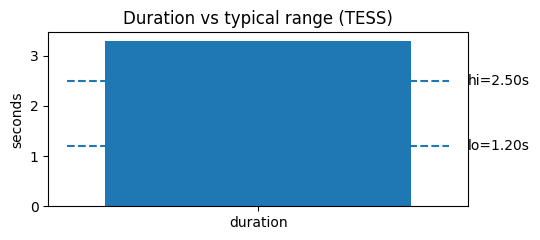

Peak amplitude           : 0.9500 → reasonable; normalization optional.
RMS (dB)                 : -20.66 → typical dialog range.
Mean amplitude           : 0.0000 → centered near zero.
Leading silence (ms)     : 1021 → trim recommended.
Trailing silence (ms)    : 1050 → trim recommended.
Clipping (%)             : 0.000 → low.

--- AFTER TRIMMING ---

Diagnostics
Sample rate (Hz)         : 22050 → OK (matches target).
Duration (sec)           : 1.231 → OK (within typical TESS range 1.20–2.50s).
Peak amplitude           : 0.9500 → reasonable; normalization optional.
RMS (dB)                 : -16.38 → typical dialog range.
Mean amplitude           : 0.0001 → centered near zero.
Leading silence (ms)     : 0 → minimal.
Trailing silence (ms)    : 0 → minimal.
Clipping (%)             : 0.000 → low.


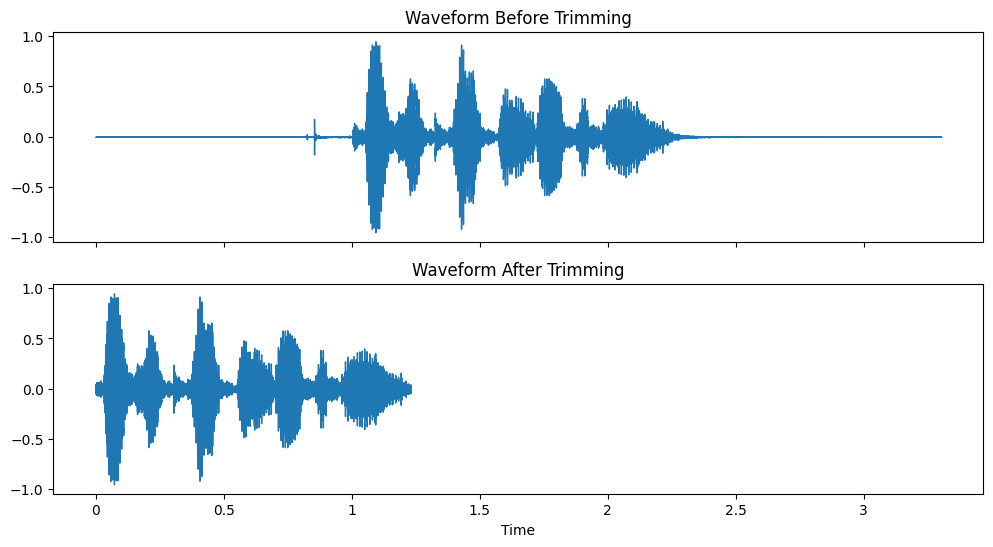

In [16]:
# --- Configuration for Phase 2 ---
# The 'top_db' tells librosa how aggressively to trim. 20 is a safe, conservative value.
TRIM_DB = 20

# --- Phase 2 Cleaning Function ---
def trim_silence(y, top_db=TRIM_DB):
    """
    Trims leading and trailing silence from an audio signal.
    This is a content-aware operation.
    """
    y_trimmed, _ = librosa.effects.trim(y, top_db=top_db)
    return y_trimmed

# --- Demonstration: The Effect of Trimming Silence ---
# We will use the same hardcoded RAVDESS file for a consistent demonstration.
demo_path = "/content/data/speech_emotion_ravdess_tess_crema/RAVDESS/Actor_01/03-01-01-01-01-01-01.wav"

# Safety check
if os.path.exists(demo_path):

    # First, get the standardized audio (the output of Phase 1) to use as our starting point.
    # This assumes the 'preprocess_audio' function from the previous cell is still in memory.
    standardized_y, sr = preprocess_audio(demo_path)

    # --- BEFORE running Phase 2 ---
    stats_before_trim = audio_stats(standardized_y, sr)
    print("="*80)
    print("DEMONSTRATION: APPLYING PHASE 2 (TRIMMING SILENCE)")
    print("="*80)
    print("\n--- BEFORE TRIMMING (but after standardization) ---")
    print_stats(stats_before_trim, path_for_context=demo_path)

    # --- RUN Phase 2 ---
    # Now, apply the trimming function to the standardized audio
    trimmed_y = trim_silence(standardized_y)

    # --- AFTER running Phase 2 ---
    stats_after_trim = audio_stats(trimmed_y, sr)
    print("\n--- AFTER TRIMMING ---")
    print_stats(stats_after_trim, path_for_context=demo_path)

    # --- VISUAL COMPARISON ---
    fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(12, 6))
    librosa.display.waveshow(standardized_y, sr=sr, ax=ax[0])
    ax[0].set(title='Waveform Before Trimming')
    ax[0].label_outer()
    librosa.display.waveshow(trimmed_y, sr=sr, ax=ax[1])
    ax[1].set(title='Waveform After Trimming')
    plt.show()

else:
    print(f"ERROR: Demo file not found at the specified path: {demo_path}")

**`Full Pipeline - Cleaning, Feature Extraction, and Caching`**<br>
This code creates the final processing pipeline. For each audio file, it will:

Apply Phase 1 (resample, mono, normalize).

Apply Phase 2 (conditionally trim silence).

Convert the clean audio into a log-mel spectrogram (a standard "image" of the sound).

Save the resulting spectrogram to a new cache directory for fast access during model training.

Final features will be saved to: /content/data/speech_emotion_ravdess_tess_crema/features_log_mel

Processing 10882 files. This will create the final features for modeling.


Creating Features:   0%|          | 0/10882 [00:00<?, ?it/s]


--- Feature Extraction Complete ---
Successfully created and cached features for 10882 / 10882 files.

--- Verifying a Sample Feature File ---
Loaded sample feature from: OAF_rose_angry.npy
Feature shape: (128, 61) (mel_bins, time_frames)


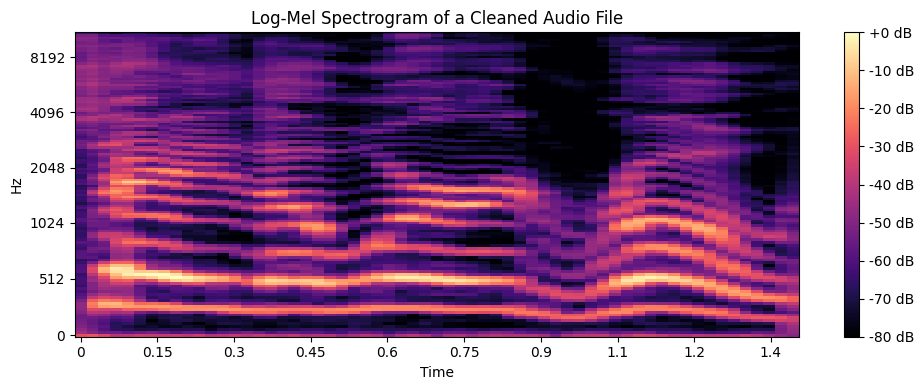

In [17]:
# --- Configuration ---
TARGET_SR = 22050
TARGET_AMP = 0.95
TRIM_DB = 20

# Librosa feature extraction parameters
N_FFT = 2048
HOP_LENGTH = 512
N_MELS = 128

# --- Feature Cache Directory ---
FEATURES_DIR = os.path.join(LOCAL_ROOT, "features_log_mel")
os.makedirs(FEATURES_DIR, exist_ok=True)
print(f"Final features will be saved to: {FEATURES_DIR}")


# --- All-in-One Processing Function ---

def clean_and_extract_features(row):
    """
    Takes a row from eda_flags, runs the full cleaning pipeline,
    extracts log-mel features, and saves them to a file.
    """
    original_path = row['path']
    needs_trim = row['needs_trim']

    # Define the final path for the cached .npy feature file
    base_name = os.path.basename(original_path).replace('.wav', '.npy')
    feature_path = os.path.join(FEATURES_DIR, base_name)

    # If the feature file already exists, skip processing.
    if os.path.exists(feature_path):
        return feature_path

    try:
        # Phase 1: Minimal Standardization
        y, sr = librosa.load(original_path, sr=TARGET_SR, mono=True)
        y = librosa.util.normalize(y, norm=np.inf) * TARGET_AMP

        # Phase 2: Content-Aware Cleaning (Conditional)
        if needs_trim:
            y, _ = librosa.effects.trim(y, top_db=TRIM_DB)
            # Re-normalize after trimming
            y = librosa.util.normalize(y, norm=np.inf) * TARGET_AMP

        # Step 5: Feature Extraction
        mel_spectrogram = librosa.feature.melspectrogram(
            y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS
        )
        # Convert to decibels (log scale)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Save the final feature array
        np.save(feature_path, log_mel_spectrogram)
        return feature_path

    except Exception as e:
        print(f"Error processing {original_path}: {e}")
        return None

# --- Batch Processing ---
print(f"\nProcessing {len(eda_flags)} files. This will create the final features for modeling.")
tqdm.pandas(desc="Creating Features")
eda_flags['feature_path'] = eda_flags.progress_apply(clean_and_extract_features, axis=1)

print("\n--- Feature Extraction Complete ---")
processed_count = eda_flags['feature_path'].notna().sum()
print(f"Successfully created and cached features for {processed_count} / {len(eda_flags)} files.")

# --- Verification Step ---
print("\n--- Verifying a Sample Feature File ---")
# Load one of the feature files we just created
try:
    sample_feature_path = eda_flags['feature_path'].dropna().iloc[0]
    sample_feature = np.load(sample_feature_path)

    print(f"Loaded sample feature from: {os.path.basename(sample_feature_path)}")
    print(f"Feature shape: {sample_feature.shape} (mel_bins, time_frames)")

    # Display the spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(sample_feature, sr=TARGET_SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log-Mel Spectrogram of a Cleaned Audio File')
    plt.tight_layout()
    plt.show()

except (IndexError, NameError):
    print("Could not load a sample feature to display.")

EDA on Extracted Features (Log-Mel Spectrograms)

--- EDA Part 1: Sample Spectrograms per Emotion ---


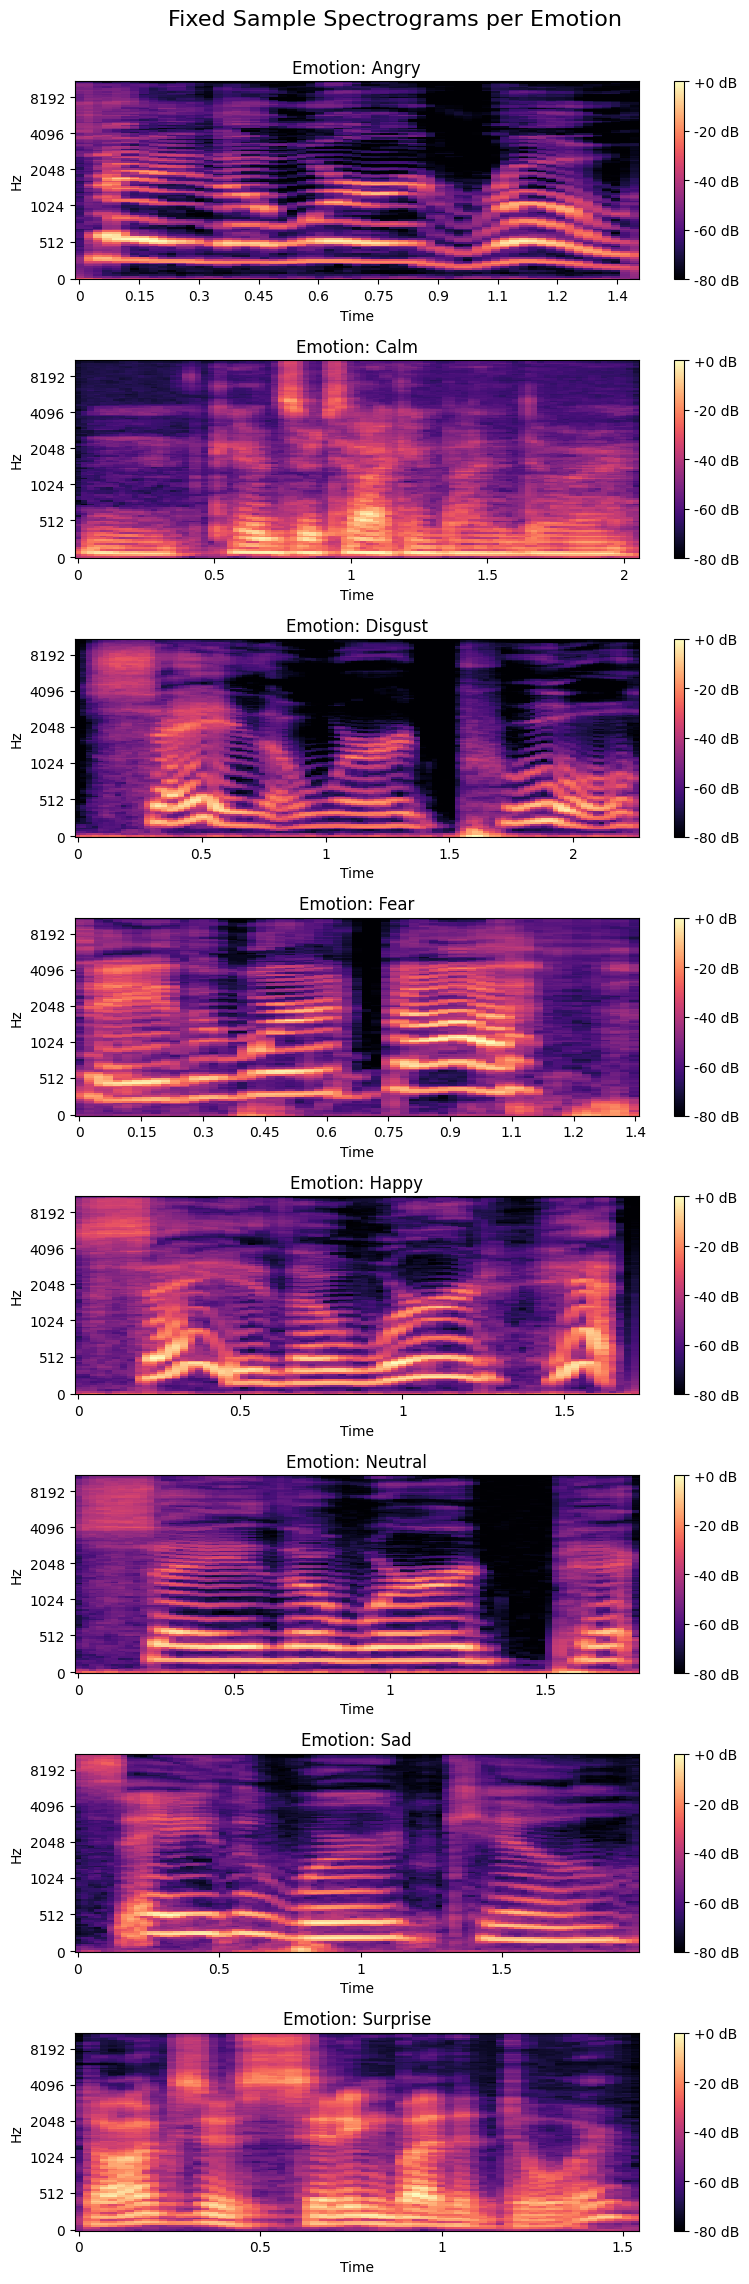


--- EDA Part 2: Average Spectrograms per Emotion ---
Calculating averages... this may take a moment.


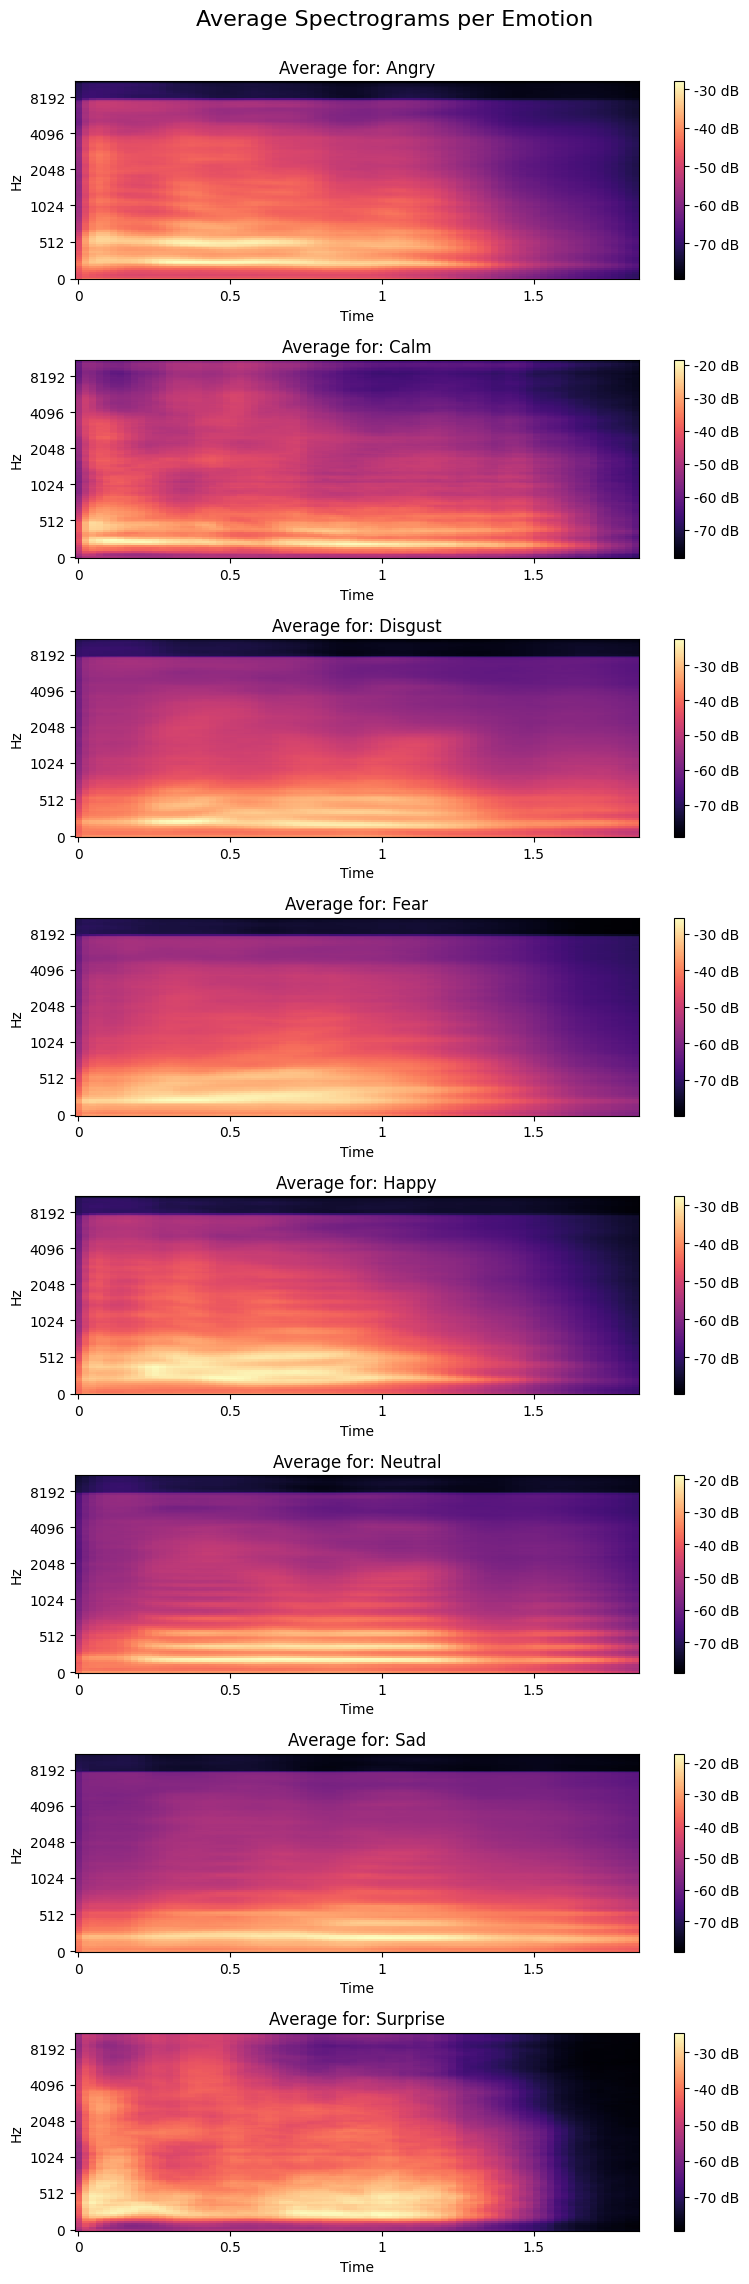

In [18]:

# Ensure the eda_flags DataFrame from the previous step exists
assert 'eda_flags' in globals() and 'feature_path' in eda_flags.columns, \
    "Please run the previous cell to create the 'eda_flags' DataFrame with 'feature_path'."

# --- Part 1: Visualize a Fixed Sample from Each Emotion ---

# Get a list of unique emotions that were successfully processed
valid_emotions = sorted(eda_flags.dropna(subset=['feature_path'])['emotion'].unique())
n_emotions = len(valid_emotions)

print("--- EDA Part 1: Sample Spectrograms per Emotion ---")

# Create a grid of plots
fig, axes = plt.subplots(nrows=n_emotions, ncols=1, figsize=(8, n_emotions * 3))
fig.suptitle("Fixed Sample Spectrograms per Emotion", fontsize=16)

for i, emo in enumerate(valid_emotions):
    # --- MODIFIED ---
    # Replaced .sample(1) with .iloc[0] to deterministically select the FIRST file
    # for each emotion. This ensures the same plot is generated every time.
    sample_row = eda_flags[eda_flags['emotion'] == emo].dropna(subset=['feature_path']).iloc[0]
    feature = np.load(sample_row['feature_path'])

    ax = axes[i]
    img = librosa.display.specshow(feature, sr=TARGET_SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel', ax=ax)
    ax.set_title(f"Emotion: {emo.capitalize()}")
    fig.colorbar(img, ax=ax, format='%+2.0f dB')

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()


# --- Part 2: Visualize the AVERAGE Spectrogram for Each Emotion ---
# This part is already deterministic and does not need to be changed.

print("\n--- EDA Part 2: Average Spectrograms per Emotion ---")
print("Calculating averages... this may take a moment.")

# First, determine a common length to resize all spectrograms to (e.g., the median length)
all_lengths = [np.load(p).shape[1] for p in eda_flags['feature_path'].dropna()]
target_len = int(np.median(all_lengths))

def pad_or_truncate(array, length):
    """Pads or truncates a 2D array along the time axis (axis=1)."""
    if array.shape[1] > length:
        return array[:, :length]
    else:
        padding = length - array.shape[1]
        return np.pad(array, ((0, 0), (0, padding)), mode='constant', constant_values=array.min())

# Create a new grid for the average plots
fig, axes = plt.subplots(nrows=n_emotions, ncols=1, figsize=(8, n_emotions * 3))
fig.suptitle("Average Spectrograms per Emotion", fontsize=16)

for i, emo in enumerate(valid_emotions):
    # Get all feature paths for the current emotion
    emotion_paths = eda_flags[eda_flags['emotion'] == emo]['feature_path'].dropna().tolist()

    # Load, resize, and stack all spectrograms for this emotion
    resized_spectrograms = [pad_or_truncate(np.load(p), target_len) for p in emotion_paths]

    if resized_spectrograms:
        # Calculate the mean across all samples
        average_spectrogram = np.mean(np.stack(resized_spectrograms), axis=0)

        ax = axes[i]
        img = librosa.display.specshow(average_spectrogram, sr=TARGET_SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel', ax=ax)
        ax.set_title(f"Average for: {emo.capitalize()}")
        fig.colorbar(img, ax=ax, format='%+2.0f dB')

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

**Creating Speaker-Disjoint Data Splits**

This is one of the most critical steps in building a reliable audio emotion recognition model. <br>

**Why This Step is Crucial**
To ensure that the model is truly learning to identify emotions and not just memorizing the voices of specific speakers, the "speaker-disjoint" (or speaker-independent) splits was created. This means that a single speaker can only appear in one of the sets (training, validation, or testing).

**This script will:**

Extract a unique Speaker ID for every audio file.

Split the list of speakers into train, validation, and test groups.

Create the final dataframes based on this speaker split.

Verify that there is no speaker overlap between the sets.

In [19]:
# Ensure the eda_flags DataFrame from the previous step exists
assert 'eda_flags' in globals() and 'feature_path' in eda_flags.columns, \
    "Please run the previous cell to create the 'eda_flags' DataFrame."

# --- Step 1: Extract Speaker ID for Each File ---

def get_speaker_id(row):
    """Extracts the speaker ID based on the dataset and file path."""
    dataset = row['dataset']
    path = row['path']

    if dataset == 'RAVDESS':
        # Path: .../RAVDESS/Actor_14/03-01-02-01-02-01-14.wav
        # The folder name 'Actor_14' is a reliable ID.
        match = re.search(r'Actor_(\d+)', path)
        if match:
            return f"ravdess_{match.group(1)}"

    elif dataset == 'TESS':
        # Path: .../TESS/OAF_angry/OAF_back_angry.wav
        # The two speakers are 'OAF' (Older) and 'YAF' (Younger).
        if 'OAF_' in path:
            return 'tess_OAF'
        elif 'YAF_' in path:
            return 'tess_YAF'

    elif dataset == 'CREMA-D':
        # Filename: 1076_MTI_SAD_XX.wav
        # The first part of the filename is the speaker ID.
        filename = os.path.basename(path)
        return f"crema_{filename.split('_')[0]}"

    return None

# Apply the function to create a new 'speaker_id' column
eda_flags['speaker_id'] = eda_flags.apply(get_speaker_id, axis=1)

print("--- Speaker ID Extraction Complete ---")
print("Sample of Speaker IDs:")
print(eda_flags[['dataset', 'speaker_id']].sample(5))


# --- Step 2: Split Speakers into Train, Validation, and Test Sets ---

# Get a unique, sorted list of all speaker IDs
all_speakers = sorted(eda_flags['speaker_id'].unique())
np.random.seed(42) # for reproducibility
np.random.shuffle(all_speakers)

# Define split proportions
train_split = 0.8
val_split = 0.1
# Test split will be the remainder

# Split the list of speakers
train_speakers, val_speakers, test_speakers = np.split(all_speakers, [
    int(len(all_speakers) * train_split),
    int(len(all_speakers) * (train_split + val_split))
])

print(f"\n--- Speaker Split ---")
print(f"Total Speakers: {len(all_speakers)}")
print(f"Training Speakers: {len(train_speakers)}")
print(f"Validation Speakers: {len(val_speakers)}")
print(f"Test Speakers: {len(test_speakers)}")


# --- Step 3: Create Final DataFrames ---

train_df = eda_flags[eda_flags['speaker_id'].isin(train_speakers)].copy()
val_df = eda_flags[eda_flags['speaker_id'].isin(val_speakers)].copy()
test_df = eda_flags[eda_flags['speaker_id'].isin(test_speakers)].copy()

print("\n--- Final DataFrame Sizes ---")
print(f"Training set size:   {len(train_df)} files")
print(f"Validation set size: {len(val_df)} files")
print(f"Test set size:       {len(test_df)} files")


# --- Step 4: Verification ---

# Check for any speaker overlap between sets
train_speaker_set = set(train_df['speaker_id'].unique())
val_speaker_set = set(val_df['speaker_id'].unique())
test_speaker_set = set(test_df['speaker_id'].unique())

assert len(train_speaker_set.intersection(val_speaker_set)) == 0, "Overlap found between train and val speakers!"
assert len(train_speaker_set.intersection(test_speaker_set)) == 0, "Overlap found between train and test speakers!"
assert len(val_speaker_set.intersection(test_speaker_set)) == 0, "Overlap found between val and test speakers!"

print("\n✅ Verification Successful: No speaker overlap found between sets.")


# --- Step 5: Review Emotion Distribution ---

print("\n--- Emotion Distribution in Each Set ---")
print("\nTraining Set:")
print(train_df['emotion'].value_counts().sort_index())
print("\nValidation Set:")
print(val_df['emotion'].value_counts().sort_index())
print("\nTest Set:")
print(test_df['emotion'].value_counts().sort_index())

--- Speaker ID Extraction Complete ---
Sample of Speaker IDs:
      dataset  speaker_id
2724  RAVDESS  ravdess_12
3927  CREMA-D  crema_1035
5895  CREMA-D  crema_1091
8277  CREMA-D  crema_1030
5232  CREMA-D  crema_1004

--- Speaker Split ---
Total Speakers: 117
Training Speakers: 93
Validation Speakers: 12
Test Speakers: 12

--- Final DataFrame Sizes ---
Training set size:   7951 files
Validation set size: 895 files
Test set size:       2036 files

✅ Verification Successful: No speaker overlap found between sets.

--- Emotion Distribution in Each Set ---

Training Set:
emotion
angry       1383
calm         136
disgust     1383
fear        1183
happy       1383
neutral     1164
sad         1183
surprise     136
Name: count, dtype: int64

Validation Set:
emotion
angry       144
calm         32
disgust     144
fear        144
happy       144
neutral     111
sad         144
surprise     32
Name: count, dtype: int64

Test Set:
emotion
angry       336
calm         24
disgust     336
fear     

--- Visualizing Overall Emotion Distribution ---


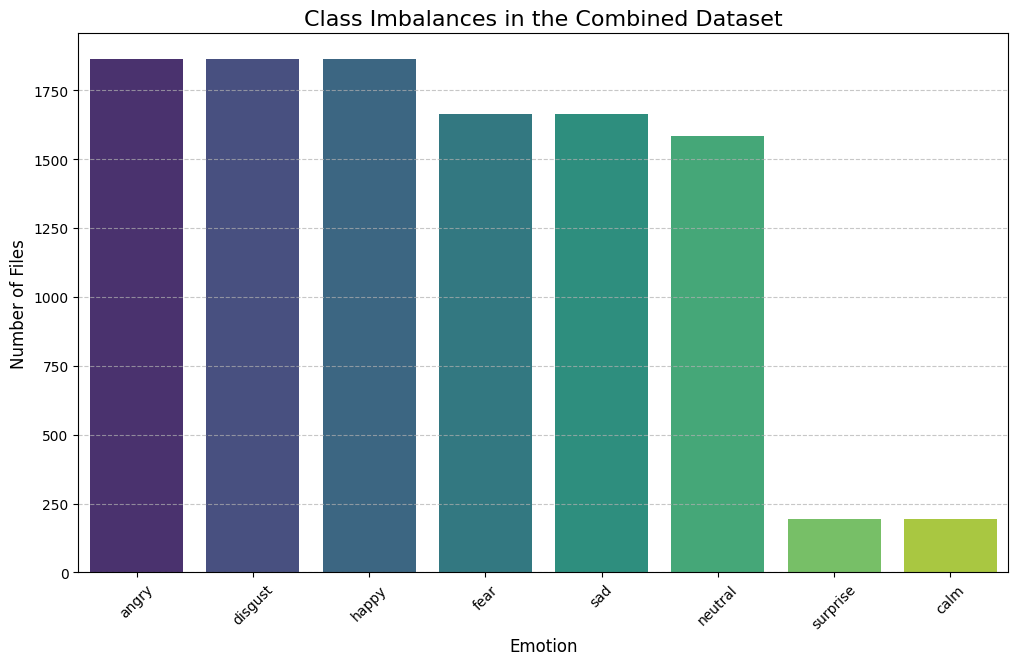

In [20]:

assert 'eda_flags' in globals(), "Please run the previous cells to create the 'eda_flags' DataFrame."

print("--- Visualizing Overall Emotion Distribution ---")

# Calculate the counts for each emotion in the full dataset
emotion_counts = eda_flags['emotion'].value_counts()

# Create the bar plot
plt.figure(figsize=(12, 7))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette="viridis")

plt.title('Class Imbalances in the Combined Dataset', fontsize=16)
plt.ylabel('Number of Files', fontsize=12)
plt.xlabel('Emotion', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# Data Preparation (Part 1): Label Encoding & Finding Target Length
This first block handles the preliminary setup. It encodes the text labels into numbers and then calculates the single, uniform length that all feature vectors will be resized to.

In [21]:
from sklearn.preprocessing import LabelEncoder

# --- Step 1: Encode Emotion Labels ---
# This step converts the string labels ('happy', 'sad') into integers.

# Ensure the DataFrames from the splitting step exist
assert 'train_df' in globals(), "Please run the data splitting cell first."

# We create the encoder and fit it ONLY on the training data to avoid data leakage.
label_encoder = LabelEncoder()
train_df['emotion_encoded'] = label_encoder.fit_transform(train_df['emotion'])
val_df['emotion_encoded'] = label_encoder.transform(val_df['emotion'])
test_df['emotion_encoded'] = label_encoder.transform(test_df['emotion'])

print("--- Label Encoding Complete ---")
# Show the mapping from text to number
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")

# --- Step 2: Pre-calculation to Find a Uniform Feature Length ---
print("\n--- Determining a uniform feature length... ---")
# We'll check the length of every feature to find the median, which is robust to outliers.
all_feature_paths = eda_flags['feature_path'].dropna().tolist()
all_lengths = [np.load(p).shape[1] for p in tqdm(all_feature_paths, desc="Checking feature lengths")]

# This is the target number of time_frames for every spectrogram
TARGET_LEN = int(np.median(all_lengths))
# N_MELS was defined in the feature extraction step (e.g., 128)
UNIFORM_FEATURE_SIZE = TARGET_LEN * N_MELS

print(f"\nTarget number of time frames set to: {TARGET_LEN}")
print(f"All feature vectors will be resized to a uniform size of {UNIFORM_FEATURE_SIZE} features.")

--- Label Encoding Complete ---
angry: 0
calm: 1
disgust: 2
fear: 3
happy: 4
neutral: 5
sad: 6
surprise: 7

--- Determining a uniform feature length... ---


Checking feature lengths:   0%|          | 0/10882 [00:00<?, ?it/s]


Target number of time frames set to: 80
All feature vectors will be resized to a uniform size of 10240 features.


#Data Preparation (Part 2): Audio Augmentation for Training Only + Padding & Truncating Features
Now that TARGET_LEN has been calculated, this block defines a function that loads each saved spectrogram (.npy),applies audio augmentation to training data only, and then pads or truncates it so every spectrogram has the same time length.

**How it works:**

1.   Load the spectrogram from disk.
2.   If training mode is enabled (train_mode=True):


*   Apply spectrogram augmentation (e.g., time masking, frequency masking) to introduce controlled variability in the training data, helping the model generalize better and reduce overfitting.
*   Validation and test data remain clean (no augmentation) to ensure evaluation is fair and reflects real-world performance.


3.   Pad or truncate the spectrogram along the time axis to exactly TARGET_LEN:


*   Truncate if the spectrogram is longer.
*   Pad with the minimum value (representing silence) if it’s shorter.

4.   Flatten the 2D spectrogram into a 1D feature vector for model input.
5.   Collect these feature vectors for:

*   X_train → with augmentation
*   X_val and X_test → without augmentation

**Why this step is important:**

Uniform length ensures that all samples have the same feature size, which is required for most machine learning models.

Augmentation on training only improves robustness without contaminating validation or test performance measurements.

Keeping validation/test clean avoids artificial score inflation and ensures metrics reflect performance on real, unseen data.

In [22]:
# Ensure the TARGET_LEN variable from the previous cell exists
assert 'TARGET_LEN' in globals(), "Please run the previous cell to calculate TARGET_LEN first."

# --- Augmentation functions ---


AUG_P = 0.5                # chance to apply augmentation
PITCH_STEPS = (-1.0, 1.0)  # semitone range for pitch shift
STRETCH_RANGE = (0.95, 1.05)
SNR_DB = (20, 30)          # noise strength

def maybe_augment_wave(y, sr, train_mode=False):
    if not train_mode or random.random() > AUG_P:
        return y
    choice = random.choice(["pitch", "stretch", "noise", "none", "none"])  # bias to do nothing
    if choice == "pitch":
        steps = random.uniform(*PITCH_STEPS)
        y = librosa.effects.pitch_shift(y, sr, n_steps=steps)
    elif choice == "stretch":
        rate = random.uniform(*STRETCH_RANGE)
        y = librosa.effects.time_stretch(y, rate)
    elif choice == "noise":
        snr = random.uniform(*SNR_DB)
        sig_pow = np.mean(y**2) + 1e-12
        noise_pow = sig_pow / (10**(snr/10))
        y = y + np.random.normal(0, np.sqrt(noise_pow), size=y.shape)
    return y

def spec_augment(S, max_time_mask=0.1, max_freq_mask=0.1, n_masks=1, train_mode=False):
    if not train_mode:
        return S
    S = S.copy()
    F, T = S.shape
    for _ in range(n_masks):
        # time mask
        t = int(T * max_time_mask)
        if t > 0:
            t0 = np.random.randint(0, max(1, T - t))
            S[:, t0:t0+t] = S[:, t0:t0+t].mean()
        # freq mask
        f = int(F * max_freq_mask)
        if f > 0:
            f0 = np.random.randint(0, max(1, F - f))
            S[f0:f0+f, :] = S[f0:f0+f, :].mean()
    return S

# --- Function to Load, Pad/Truncate, Apply Augmentation, and Flatten Features ---
from tqdm import tqdm

def load_and_process_features(df, target_len, train_mode=False):
    """
    Loads spectrograms, applies augmentation if train_mode=True, resizes to a target length,
    and flattens them into vectors.
    """
    features = []
    for feature_path in tqdm(df['feature_path'], desc="Loading and Resizing Features"):
        spectrogram = np.load(feature_path)

        # Apply spectrogram augmentation for training
        if train_mode:
            spectrogram = spec_augment(spectrogram, train_mode=True)

        # Pad or truncate the spectrogram on the time axis (axis=1)
        if spectrogram.shape[1] > target_len:
            spectrogram = spectrogram[:, :target_len]  # Truncate
        else:
            padding = target_len - spectrogram.shape[1]
            spectrogram = np.pad(
                spectrogram,
                ((0, 0), (0, padding)),
                mode='constant',
                constant_values=spectrogram.min()
            )

        features.append(spectrogram.flatten())

    return np.array(features)

# --- Load and Process the Data Splits ---
X_train = load_and_process_features(train_df, TARGET_LEN, train_mode=True)
X_val   = load_and_process_features(val_df, TARGET_LEN, train_mode=False)
X_test  = load_and_process_features(test_df, TARGET_LEN, train_mode=False)

# Get the corresponding encoded labels from the DataFrames
y_train = train_df['emotion_encoded'].values
y_val = val_df['emotion_encoded'].values
y_test = test_df['emotion_encoded'].values

# --- Verification ---
print("\n--- Data Preparation Complete ---")
print(f"Shape of X_train (features): {X_train.shape}")
print(f"Shape of y_train (labels):   {y_train.shape}")
print(f"\nShape of X_val (features):   {X_val.shape}")
print(f"Shape of y_val (labels):     {y_val.shape}")
print(f"\nShape of X_test (features):  {X_test.shape}")
print(f"Shape of y_test (labels):    {y_test.shape}")


Loading and Resizing Features: 100%|██████████| 2036/2036 [00:00<00:00, 5616.35it/s]



--- Data Preparation Complete ---
Shape of X_train (features): (7951, 10240)
Shape of y_train (labels):   (7951,)

Shape of X_val (features):   (895, 10240)
Shape of y_val (labels):     (895,)

Shape of X_test (features):  (2036, 10240)
Shape of y_test (labels):    (2036,)


**Calculating class weights**<br>
Augmentation and padding/truncating happen to the features, while class weight calculation is based on the label distribution in the original train_df['emotion'].


In [23]:
from sklearn.utils.class_weight import compute_class_weight

# Ensure the train_df DataFrame from the splitting step exists
assert 'train_df' in globals(), "Please run the data splitting cell first to create 'train_df'."

print("--- Calculating Class Weights ---")

# Get the list of unique classes from the training data
class_labels = np.unique(train_df['emotion'])

# Calculate the weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=train_df['emotion']
)


# Create a dictionary mapping the ENCODED INTEGER LABELS (0, 1, 2...) to the weights.
# The label_encoder.transform() correctly converts string labels to their integer representation.
class_weights = dict(zip(label_encoder.transform(class_labels), class_weights_array))

print("Successfully calculated class weights with INTEGER keys:\n")
# We use label_encoder.classes_ to show the original emotion name for readability
for i, label in enumerate(label_encoder.classes_):
    print(f"{label:<10} (label {i}): {class_weights[i]:.4f}")

--- Calculating Class Weights ---
Successfully calculated class weights with INTEGER keys:

angry      (label 0): 0.7186
calm       (label 1): 7.3079
disgust    (label 2): 0.7186
fear       (label 3): 0.8401
happy      (label 4): 0.7186
neutral    (label 5): 0.8538
sad        (label 6): 0.8401
surprise   (label 7): 7.3079


Scaling the Data

In [24]:
from sklearn.preprocessing import StandardScaler


# Ensure the feature sets (X_train, X_val, X_test) from the previous step exist
assert 'X_train' in globals(), "Please run the previous data preparation cell first."

print("--- Scaling Features ---")

# 1. Initialize the Scaler
scaler = StandardScaler()

# 2. Fit on the training data ONLY and transform it
X_train_scaled = scaler.fit_transform(X_train)

# 3. Transform the validation and test data using the SAME fitted scaler
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# --- Verification Step (with improved formatting) ---
print("Scaling complete.")
print(f"\nOriginal X_train shape: {X_train.shape}")
print(f"Scaled X_train shape:   {X_train_scaled.shape}")

# Create a DataFrame to display the stats in a clean table
verification_data = {
    'Train Mean': np.mean(X_train_scaled[:, :5], axis=0),
    'Train Std Dev': np.std(X_train_scaled[:, :5], axis=0),
    'Test Mean': np.mean(X_test_scaled[:, :5], axis=0),
    'Test Std Dev': np.std(X_test_scaled[:, :5], axis=0),
}
verification_df = pd.DataFrame(
    verification_data,
    index=[f'Feature {i}' for i in range(5)]
)

# Format the numbers in the table for better readability
pd.options.display.float_format = '{:.6f}'.format

print("\n--- Verification of Scaled Features (First 5 Features) ---")
display(verification_df)

# Reset float format to default if you want
# pd.options.display.float_format = None

--- Scaling Features ---
Scaling complete.

Original X_train shape: (7951, 10240)
Scaled X_train shape:   (7951, 10240)

--- Verification of Scaled Features (First 5 Features) ---


,Train Mean,Train Std Dev,Test Mean,Test Std Dev
Feature 0,0.000000,0.999999,-0.519338,0.977507
Feature 1,-0.000000,0.999998,-0.491996,0.951588
Feature 2,0.000000,1.000000,-0.475742,0.940665
Feature 3,-0.000000,1.000000,-0.468272,0.950023
Feature 4,0.000000,1.000000,-0.449640,0.968205


**`Training Baseline Machine Learning Models`**
This script will train the first three required traditional models: Logistic Regression, Random Forest, and LGBMClassifier.

It uses the scaled data (X_train_scaled, y_train) and, most importantly, passes the class_weights dictionary to each model to handle the data imbalance. Performance is measured on the validation set.

In [25]:


assert 'X_train_scaled' in globals() and 'class_weights' in globals()

# Quiet LightGBM logs + warnings
warnings.filterwarnings("ignore", module="lightgbm")
os.environ["LIBOMP_WARN"] = "0"

CPU = os.cpu_count() or 4
N_WORKERS = max(1, CPU - 1)   # keep 1 core free

# --- small stratified subset for fast iteration ---
MAX_SAMPLES = 1500  # tweak as needed
sss = StratifiedShuffleSplit(n_splits=1, train_size=min(MAX_SAMPLES, len(y_train)), random_state=42)
idx_small, _ = next(sss.split(X_train_scaled, y_train))
Xtr_small, ytr_small = X_train_scaled[idx_small], y_train[idx_small]
print(f"Subset for fast baselines: {len(ytr_small)} rows")

# --- models (parallelized where it matters) ---
models = {
    "Logistic Regression": LogisticRegression(
        solver="saga", C=1.0, max_iter=2000, class_weight=class_weights
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=600, max_depth=None, n_jobs=N_WORKERS,
        class_weight=class_weights, random_state=42
    ),
    "LightGBM": LGBMClassifier(
        objective="multiclass", class_weight=class_weights,
        n_estimators=800, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8,
        n_jobs=N_WORKERS, random_state=42,
        verbose=-1  # <— suppress LightGBM training spam
    ),
}

def _auc_ovr(y_true, proba):
    try:
        return roc_auc_score(y_true, proba, multi_class='ovr')
    except Exception:
        return np.nan

def _diagnose(acc_tr, acc_va, f1_tr, f1_va, tol=0.05):
    gap_acc = (acc_tr - acc_va)
    gap_f1  = (f1_tr - f1_va)
    if (acc_tr > 0.90 and gap_acc >= tol) or (f1_tr > 0.90 and gap_f1 >= tol) or (gap_acc >= tol and gap_f1 >= tol):
        status = "Overfitting"
    elif (acc_tr < 0.70 and acc_va < 0.70) and (f1_tr < 0.70 and f1_va < 0.70):
        status = "Underfitting"
    else:
        status = "Reasonable fit"
    return status, gap_acc * 100.0, gap_f1 * 100.0

pd.options.display.float_format = '{:.4f}'.format

for name, model in models.items():
    print("="*80, f"\nTraining {name} on subset...")
    model.fit(Xtr_small, ytr_small)

    # --- preds + probas ---
    y_tr = model.predict(Xtr_small)
    y_va = model.predict(X_val_scaled)
    proba_fn = getattr(model, "predict_proba", None)
    auc_tr = _auc_ovr(ytr_small, proba_fn(Xtr_small)) if proba_fn else np.nan
    auc_va = _auc_ovr(y_val,      proba_fn(X_val_scaled)) if proba_fn else np.nan

    # --- metrics ---
    acc_tr = accuracy_score(ytr_small, y_tr)
    acc_va = accuracy_score(y_val, y_va)
    f1m_tr = f1_score(ytr_small, y_tr, average='macro')
    f1m_va = f1_score(y_val, y_va, average='macro')
    bal_tr = balanced_accuracy_score(ytr_small, y_tr)
    bal_va = balanced_accuracy_score(y_val, y_va)
    kap_tr = cohen_kappa_score(ytr_small, y_tr)
    kap_va = cohen_kappa_score(y_val, y_va)
    mcc_tr = matthews_corrcoef(ytr_small, y_tr)
    mcc_va = matthews_corrcoef(y_val, y_va)

    # === NEW: compact summary like your SVM printout (kept + expanded) ===
    print(f"Training Accuracy of {name}: {acc_tr*100:.2f}%")
    print(f"Accuracy (Validation) score of {name}: {acc_va*100:.2f}%")
    print(f"F1-macro (Train): {f1m_tr*100:.2f}%")
    print(f"F1-macro (Validation): {f1m_va*100:.2f}%")
    print(f"AUC (OvR) - Train: {auc_tr:.6f} | Val: {auc_va:.6f}")

    status, gap_acc_pp, gap_f1_pp = _diagnose(acc_tr, acc_va, f1m_tr, f1m_va)
    print(f"Fit diagnosis: {status} (Train–Val gaps → Accuracy: {gap_acc_pp:.2f} pp, F1: {gap_f1_pp:.2f} pp)")

    # === keep your existing full table ===
    dfm = pd.DataFrame({
        "Train":[acc_tr, f1m_tr, bal_tr, auc_tr, kap_tr, mcc_tr],
        "Val":[acc_va, f1m_va, bal_va, auc_va, kap_va, mcc_va]
    }, index=["Accuracy","F1 (macro)","Balanced Acc","ROC AUC (OvR)","Kappa","MCC"])
    display(dfm)

    # === keep your classification report ===
    print("\nValidation report:\n", classification_report(y_val, y_va, target_names=label_encoder.classes_))

    # === NEW: confusion matrices (raw + row-normalized) ===
    cm = confusion_matrix(y_val, y_va, labels=range(len(label_encoder.classes_)))
    cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
    print("\nConfusion matrix (counts):")
    display(cm_df)

    with np.errstate(invalid='ignore'):
        cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    cmn_df = pd.DataFrame(np.nan_to_num(cm_norm), index=label_encoder.classes_, columns=label_encoder.classes_)
    print("Confusion matrix (row-normalized):")
    display(cmn_df.round(3))


Subset for fast baselines: 1500 rows
Training Logistic Regression on subset...
Training Accuracy of Logistic Regression: 100.00%
Accuracy (Validation) score of Logistic Regression: 34.30%
F1-macro (Train): 100.00%
F1-macro (Validation): 29.63%
AUC (OvR) - Train: 1.000000 | Val: 0.717693
Fit diagnosis: Overfitting (Train–Val gaps → Accuracy: 65.70 pp, F1: 70.37 pp)


,Train,Val
Accuracy,1.0000,0.3430
F1 (macro),1.0000,0.2963
Balanced Acc,1.0000,0.2996
ROC AUC (OvR),1.0000,0.7177
Kappa,1.0000,0.2280
MCC,1.0000,0.2286



Validation report:
               precision    recall  f1-score   support

       angry       0.50      0.58      0.54       144
        calm       0.14      0.09      0.11        32
     disgust       0.26      0.26      0.26       144
        fear       0.31      0.22      0.25       144
       happy       0.30      0.31      0.31       144
     neutral       0.32      0.41      0.36       111
         sad       0.38      0.40      0.39       144
    surprise       0.18      0.12      0.15        32

    accuracy                           0.34       895
   macro avg       0.30      0.30      0.30       895
weighted avg       0.33      0.34      0.34       895


Confusion matrix (counts):


,angry,calm,disgust,fear,happy,neutral,sad,surprise
angry,84,2,15,12,18,8,4,1
calm,0,3,4,0,3,10,9,3
disgust,23,6,37,11,21,20,25,1
fear,29,1,17,31,25,16,19,6
happy,28,1,17,17,45,18,14,4
neutral,3,1,13,11,20,46,16,1
sad,0,5,31,17,9,23,57,2
surprise,0,2,7,1,9,1,8,4


Confusion matrix (row-normalized):


,angry,calm,disgust,fear,happy,neutral,sad,surprise
angry,0.5830,0.0140,0.1040,0.0830,0.1250,0.0560,0.0280,0.0070
calm,0.0000,0.0940,0.1250,0.0000,0.0940,0.3120,0.2810,0.0940
disgust,0.1600,0.0420,0.2570,0.0760,0.1460,0.1390,0.1740,0.0070
fear,0.2010,0.0070,0.1180,0.2150,0.1740,0.1110,0.1320,0.0420
happy,0.1940,0.0070,0.1180,0.1180,0.3120,0.1250,0.0970,0.0280
neutral,0.0270,0.0090,0.1170,0.0990,0.1800,0.4140,0.1440,0.0090
sad,0.0000,0.0350,0.2150,0.1180,0.0620,0.1600,0.3960,0.0140
surprise,0.0000,0.0620,0.2190,0.0310,0.2810,0.0310,0.2500,0.1250


Training Random Forest on subset...
Training Accuracy of Random Forest: 100.00%
Accuracy (Validation) score of Random Forest: 39.11%
F1-macro (Train): 100.00%
F1-macro (Validation): 34.93%
AUC (OvR) - Train: 1.000000 | Val: 0.797623
Fit diagnosis: Overfitting (Train–Val gaps → Accuracy: 60.89 pp, F1: 65.07 pp)


,Train,Val
Accuracy,1.0000,0.3911
F1 (macro),1.0000,0.3493
Balanced Acc,1.0000,0.3694
ROC AUC (OvR),1.0000,0.7976
Kappa,1.0000,0.2856
MCC,1.0000,0.2912



Validation report:
               precision    recall  f1-score   support

       angry       0.46      0.74      0.57       144
        calm       0.29      0.19      0.23        32
     disgust       0.36      0.28      0.31       144
        fear       0.26      0.05      0.08       144
       happy       0.27      0.36      0.31       144
     neutral       0.37      0.49      0.42       111
         sad       0.54      0.51      0.52       144
    surprise       0.35      0.34      0.35        32

    accuracy                           0.39       895
   macro avg       0.36      0.37      0.35       895
weighted avg       0.37      0.39      0.36       895


Confusion matrix (counts):


,angry,calm,disgust,fear,happy,neutral,sad,surprise
angry,106,2,5,2,15,11,1,2
calm,0,6,6,0,15,2,1,2
disgust,22,4,40,5,35,18,19,1
fear,44,0,11,7,34,15,22,11
happy,45,0,10,1,52,27,6,3
neutral,2,1,18,4,17,54,15,0
sad,6,4,20,8,13,18,74,1
surprise,6,4,0,0,11,0,0,11


Confusion matrix (row-normalized):


,angry,calm,disgust,fear,happy,neutral,sad,surprise
angry,0.7360,0.0140,0.0350,0.0140,0.1040,0.0760,0.0070,0.0140
calm,0.0000,0.1880,0.1880,0.0000,0.4690,0.0620,0.0310,0.0620
disgust,0.1530,0.0280,0.2780,0.0350,0.2430,0.1250,0.1320,0.0070
fear,0.3060,0.0000,0.0760,0.0490,0.2360,0.1040,0.1530,0.0760
happy,0.3120,0.0000,0.0690,0.0070,0.3610,0.1880,0.0420,0.0210
neutral,0.0180,0.0090,0.1620,0.0360,0.1530,0.4860,0.1350,0.0000
sad,0.0420,0.0280,0.1390,0.0560,0.0900,0.1250,0.5140,0.0070
surprise,0.1880,0.1250,0.0000,0.0000,0.3440,0.0000,0.0000,0.3440


Training LightGBM on subset...
Training Accuracy of LightGBM: 100.00%
Accuracy (Validation) score of LightGBM: 40.22%
F1-macro (Train): 100.00%
F1-macro (Validation): 34.71%
AUC (OvR) - Train: 1.000000 | Val: 0.797587
Fit diagnosis: Overfitting (Train–Val gaps → Accuracy: 59.78 pp, F1: 65.29 pp)


,Train,Val
Accuracy,1.0000,0.4022
F1 (macro),1.0000,0.3471
Balanced Acc,1.0000,0.3639
ROC AUC (OvR),1.0000,0.7976
Kappa,1.0000,0.3010
MCC,1.0000,0.3048



Validation report:
               precision    recall  f1-score   support

       angry       0.50      0.71      0.59       144
        calm       0.23      0.22      0.23        32
     disgust       0.39      0.33      0.36       144
        fear       0.43      0.13      0.20       144
       happy       0.33      0.34      0.33       144
     neutral       0.35      0.52      0.42       111
         sad       0.50      0.50      0.50       144
    surprise       0.14      0.16      0.15        32

    accuracy                           0.40       895
   macro avg       0.36      0.36      0.35       895
weighted avg       0.40      0.40      0.38       895


Confusion matrix (counts):


,angry,calm,disgust,fear,happy,neutral,sad,surprise
angry,102,3,5,2,17,11,1,3
calm,0,7,4,0,4,7,7,3
disgust,24,5,48,5,18,25,16,3
fear,31,1,16,19,27,17,23,10
happy,36,1,9,7,49,28,8,6
neutral,4,2,14,5,12,58,14,2
sad,3,7,26,6,8,19,72,3
surprise,2,4,1,0,15,3,2,5


Confusion matrix (row-normalized):


,angry,calm,disgust,fear,happy,neutral,sad,surprise
angry,0.7080,0.0210,0.0350,0.0140,0.1180,0.0760,0.0070,0.0210
calm,0.0000,0.2190,0.1250,0.0000,0.1250,0.2190,0.2190,0.0940
disgust,0.1670,0.0350,0.3330,0.0350,0.1250,0.1740,0.1110,0.0210
fear,0.2150,0.0070,0.1110,0.1320,0.1880,0.1180,0.1600,0.0690
happy,0.2500,0.0070,0.0620,0.0490,0.3400,0.1940,0.0560,0.0420
neutral,0.0360,0.0180,0.1260,0.0450,0.1080,0.5230,0.1260,0.0180
sad,0.0210,0.0490,0.1810,0.0420,0.0560,0.1320,0.5000,0.0210
surprise,0.0620,0.1250,0.0310,0.0000,0.4690,0.0940,0.0620,0.1560


Hyper parameter Tuning on LightGBM

In [ ]:
# --- LightGBM randomized search (quiet) + rich result printout ---
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform, loguniform
import lightgbm as lgb
import warnings

warnings.filterwarnings("ignore", module="lightgbm")

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

lgb_base = LGBMClassifier(
    objective="multiclass",
    class_weight=class_weights,
    n_estimators=5000,              # large cap; early stopping will pick best_iteration_
    n_jobs=N_WORKERS,
    random_state=42,
    verbose=-1                      # suppress training spam
)

param_dist = {
    "num_leaves":        randint(16, 96),
    "min_child_samples": randint(10, 200),
    "feature_fraction":  uniform(0.6, 0.4),
    "bagging_fraction":  uniform(0.6, 0.4),
    "bagging_freq":      randint(1, 7),
    "lambda_l1":         loguniform(1e-3, 10),
    "lambda_l2":         loguniform(1e-3, 10),
    "learning_rate":     loguniform(0.02, 0.2),
}

search = RandomizedSearchCV(
    estimator=lgb_base,
    param_distributions=param_dist,
    n_iter=20,
    scoring="f1_macro",
    cv=cv,
    n_jobs=N_WORKERS,
    verbose=0,          # quiet search
    refit=False,
    random_state=42
)

print("RandomizedSearchCV on subset with early stopping...")
search.fit(
    Xtr_small, ytr_small,
    eval_set=[(X_val_scaled, y_val)],
    eval_metric="multi_logloss",
    callbacks=[lgb.early_stopping(stopping_rounds=150, verbose=False)]
)
best_params = search.best_params_
print("Best params (CV on train subset):", best_params, "| Best CV F1(macro):", round(search.best_score_, 4))

# ---- Refit tuned model on subset with early stopping, then print rich summary ----
lgb_tuned = LGBMClassifier(
    objective="multiclass",
    class_weight=class_weights,
    n_estimators=5000,
    n_jobs=N_WORKERS,
    random_state=42,
    verbose=-1,
    **best_params
)

lgb_tuned.fit(
    Xtr_small, ytr_small,
    eval_set=[(X_val_scaled, y_val)],
    eval_metric="multi_logloss",
    callbacks=[lgb.early_stopping(stopping_rounds=150, verbose=False)]
)

best_iter = getattr(lgb_tuned, "best_iteration_", None)
if best_iter:
    print(f"Best iteration selected by early stopping: {best_iter}")

# --- predictions/probas ---
y_tr = lgb_tuned.predict(Xtr_small)
y_va = lgb_tuned.predict(X_val_scaled)
proba_tr = lgb_tuned.predict_proba(Xtr_small)
proba_va = lgb_tuned.predict_proba(X_val_scaled)

# --- metrics ---
acc_tr = accuracy_score(ytr_small, y_tr); acc_va = accuracy_score(y_val, y_va)
f1m_tr = f1_score(ytr_small, y_tr, average='macro'); f1m_va = f1_score(y_val, y_va, average='macro')
bal_tr = balanced_accuracy_score(ytr_small, y_tr); bal_va = balanced_accuracy_score(y_val, y_va)
kap_tr = cohen_kappa_score(ytr_small, y_tr); kap_va = cohen_kappa_score(y_val, y_va)
mcc_tr = matthews_corrcoef(ytr_small, y_tr); mcc_va = matthews_corrcoef(y_val, y_va)
auc_tr = _auc_ovr(ytr_small, proba_tr); auc_va = _auc_ovr(y_val, proba_va)

# === Sample-style summary (expanded) + fit diagnosis ===
print(f"Training Accuracy of LightGBM (tuned): {acc_tr*100:.2f}%")
print(f"Accuracy (Validation) score of LightGBM (tuned): {acc_va*100:.2f}%")
print(f"F1-macro (Train): {f1m_tr*100:.2f}%")
print(f"F1-macro (Validation): {f1m_va*100:.2f}%")
print(f"AUC (OvR) - Train: {auc_tr:.6f} | Val: {auc_va:.6f}")

status, gap_acc_pp, gap_f1_pp = _diagnose(acc_tr, acc_va, f1m_tr, f1m_va)
print(f"Fit diagnosis: {status} (Train–Val gaps → Accuracy: {gap_acc_pp:.2f} pp, F1: {gap_f1_pp:.2f} pp)")

# === full table (kept style) ===
dfm = pd.DataFrame({
    "Train":[acc_tr, f1m_tr, bal_tr, auc_tr, kap_tr, mcc_tr],
    "Val":[acc_va, f1m_va, bal_va, auc_va, kap_va, mcc_va]
}, index=["Accuracy","F1 (macro)","Balanced Acc","ROC AUC (OvR)","Kappa","MCC"])
display(dfm)

# === classification report ===
print("\nValidation report:\n", classification_report(y_val, y_va, target_names=label_encoder.classes_))

# === confusion matrices (counts + normalized) ===
cm = confusion_matrix(y_val, y_va, labels=range(len(label_encoder.classes_)))
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
print("\nConfusion matrix (counts):")
display(cm_df)

with np.errstate(invalid='ignore'):
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
cmn_df = pd.DataFrame(np.nan_to_num(cm_norm), index=label_encoder.classes_, columns=label_encoder.classes_)
print("Confusion matrix (row-normalized):")
display(cmn_df.round(3))



RandomizedSearchCV on subset with early stopping...


In [ ]:
# 1) check for NaN/Inf after scaling
import numpy as np
print("NaNs in X_train_scaled:", np.isnan(X_train_scaled).sum())
print("Infs in X_train_scaled:", np.isinf(X_train_scaled).sum())

# 2) check label harmonization — 'calm' should NOT exist if you merged to 'neutral'
print(train_df['emotion'].value_counts())


NaNs in X_train_scaled: 0
Infs in X_train_scaled: 0
emotion
angry       1383
disgust     1383
happy       1383
fear        1183
sad         1183
neutral     1164
surprise     136
calm         136
Name: count, dtype: int64
